In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import pytorch_ssim
# https://github.com/Po-Hsun-Su/pytorch-ssim
from torch.utils.data import DataLoader

In [2]:
device = "cpu"
# 选择 dataset
dataset = 'MNIST' 
# dataset = "CIFAR-10"
batch_size = 5
eps = 0.031 if dataset=="CIFAR-10" else 0.1
step_size = 0.05 if dataset=="CIFAR-10" else 0.3
iteration = 10
K = 0.05

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
if(dataset == "CIFAR-10"):
    train_dataset = torchvision.datasets.CIFAR10("data_CIFAR10",train=True,download=False,transform = transform)
    train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=False)
    from PreActResNet import PreActResNet18
    model = PreActResNet18()
    check_point = torch.load("CIFAR10_PreActResNet18.checkpoint", map_location=torch.device(device))
    model.load_state_dict(check_point['state_dict'])
else:
    train_dataset = torchvision.datasets.MNIST("data_MNIST", train=True, download=False, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    from small_cnn import SmallCNN
    model = SmallCNN()
    check_point = torch.load("MNIST_small_cnn.checkpoint", map_location=torch.device(device))
    model.load_state_dict(check_point['state_dict'])

In [4]:
# 显示一张图片（没有transpose)
def imshow(img, title):
    plt.figure(figsize = (10, 10))
    plt.imshow(np.transpose(img,(1,2,0)))
    plt.title(title)
    plt.show()

In [5]:
# 并排左右显示两张图片（没有transpose)
def double_imshow(img1,img2,title1,title2):
    plt.figure(figsize=(10,10))
    i1 = plt.subplot2grid((1, 2),(0, 0))
    plt.imshow(np.transpose(img1,(1,2,0)))
    i1.set_title(title1)
    i2 = plt.subplot2grid((1, 2), (0, 1))
    plt.imshow(np.transpose(img2, (1, 2, 0)))
    i2.set_title(title2)
    plt.show()


In [6]:
# savepath = "adv_images/SSIM, step_size = 0.15 eps = 0.3/"
# 并排左右显示三张图片（没有transpose)
def triple_imshow(img1, img2, img3, title1, title2, title3, figNum = 0):
    plt.figure(figsize=(10,10))
    i1 = plt.subplot2grid((1, 3),(0, 0))
    plt.imshow(np.transpose(img1,(1,2,0)))
    i1.set_title(title1)
    i2 = plt.subplot2grid((1, 3), (0, 1))
    plt.imshow(np.transpose(img2, (1, 2, 0)))
    i2.set_title(title2)
    i3 = plt.subplot2grid((1, 3), (0, 2))
    plt.imshow(np.transpose(img3, (1, 2, 0)))
    i3.set_title(title3)
    # sp = savepath + "img" + str(figNum) + '.png'
    # plt.savefig(sp)
    plt.show()

In [7]:
# l2 Loss
def l2(img1,img2):
    channel = img1.size()[0]
    height = img1.size()[1]
    width = img1.size()[2]
    total_dif = 0.0
    for i in range(0,channel):
        for j in range(0,height):
            for k in range(0, width):
                total_dif += (img1[i][j][k].item()-img2[i][j][k].item()) ** 2
    return total_dif ** 0.5

In [8]:
# l1 Loss
def l1(img1,img2):
    channel = img1.size()[0]
    height = img1.size()[1]
    width = img1.size()[2]
    total_dif = 0
    for i in range(0, channel):
        for j in range(0, height):
            for k in range(0, width):
                total_dif += abs(img1[i][j][k].item() - img2[i][j][k].item())
    return total_dif

In [9]:
# l0 Loss 计算差距<=0.01像素点的数目
def l0(img1,img2):
    channel = img1.size()[0]
    height = img1.size()[1]
    width = img1.size()[2]
    total_dif = 0
    for i in range(0, channel):
        for j in range(0, height):
            for k in range(0, width):
                total_dif += 0 if abs(img1[i][j][k].item() - img2[i][j][k].item()) <= 0.01 else 1
    return total_dif

In [10]:
class My_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, delta, y, images):
        mask = torch.ones_like(x).scatter_(1, y.unsqueeze(1), 0.)
        rest = x[mask.bool()].view(x.size(0), x.size(1) - 1)
        xx = torch.tensor(range(x.size(0)))
        f = torch.nn.ReLU()
        return torch.mean(f(x[xx, y] - torch.max(rest, 1)[0] + K) + (1 - (pytorch_ssim.ssim(images,images+delta))))

In [11]:
def PGD_attack_MyLoss(net, images, labels, eps, step_size):
    images = images.to(device)
    labels = labels.to(device)

    delta = torch.zeros(images.size()).to(device)  #变量求导
    delta.uniform_(-eps, eps).to(device)
    delta = Variable(delta, requires_grad=True)
    # print(images.size())
    # print(labels.size())
    # ori_images = images.data
    criterion = My_loss()
    for i in range(iteration):
        # delta.requires_grad = True
        # lam.requires_grad = True
        # print(images.size())
        outputs = net(images + delta)
        net.zero_grad()
        loss = criterion(outputs, delta, labels,images).to(device)
        loss.backward()

        # print(delta.grad)
        new_delta = delta - step_size * delta.grad.detach()
        adv_images = torch.clamp(images + new_delta, min=0, max=1)
        delta = adv_images - images
        # delta = torch.clamp(delta, min=-eps, max=eps)
        delta = Variable(delta, requires_grad=True)
        # for i in range(0, images.size()[0]):
        #     print(torch.max(delta[i]).item())
        #     print(torch.min(delta[i]).item())
    deltas = []
    for i in range(0,images.size()[0]):
        deltas.append(torch.max(torch.abs(delta[i])).item())
    return images + delta, deltas

In [12]:
def PGD_attack_Conventional(model, image, label, step_size, eps=0.3, iters=10):
    image = image.to(device)
    label = label.to(device)
    loss = nn.NLLLoss()
    ori_image = image.data

    for i in range(iters):
        image.requires_grad = True
        output = model(image)
        model.zero_grad()
        cost = loss(output, label).to(device)
        cost.backward()
        adv_image = image + step_size * image.grad.sign()
        delta = torch.clamp(adv_image - ori_image, min=-eps, max=eps)
        image = torch.clamp(ori_image + delta, min=0, max=1).detach_()
    return image

Total Image Count: 5 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Total Image Count: 10 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 1.0
Total Image Count: 15 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9333333333333333
Total Image Count: 20 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.95
Total Image Count: 25 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.96
Total Image Count: 30 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9333333333333333
Total Image Count: 35 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9428571428571428
Total Image Count: 40 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.95
Total Image Count: 45 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9555555555555556


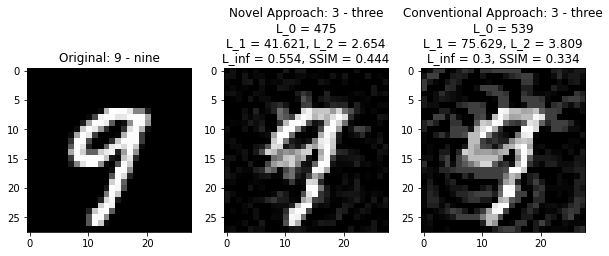

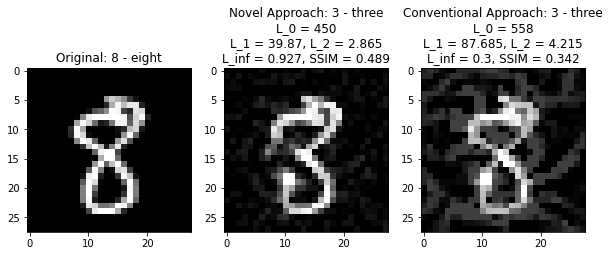

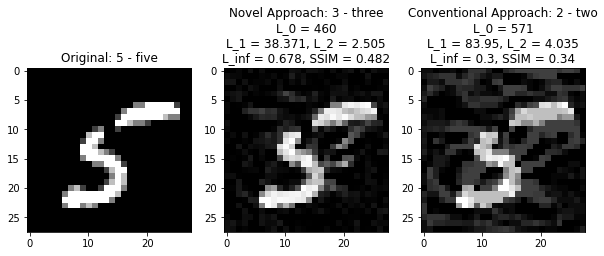

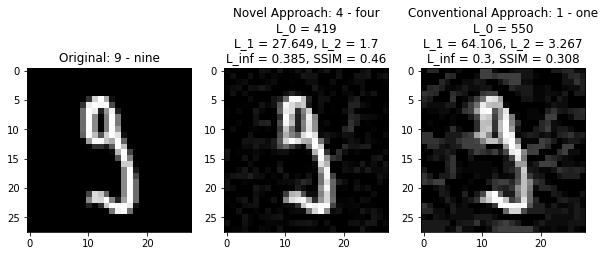

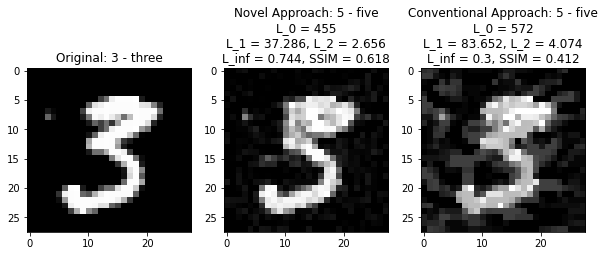

Total Image Count: 50 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.96
Total Image Count: 55 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9636363636363636
Total Image Count: 60 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9666666666666667
Total Image Count: 65 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9692307692307692
Total Image Count: 70 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9714285714285714
Total Image Count: 75 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9733333333333334
Total Image Count: 80 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.975
Total Image Count: 85 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9764705882352941
Total Image Count: 90 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9777777777777777
Total Image Count: 95 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9789473684210527


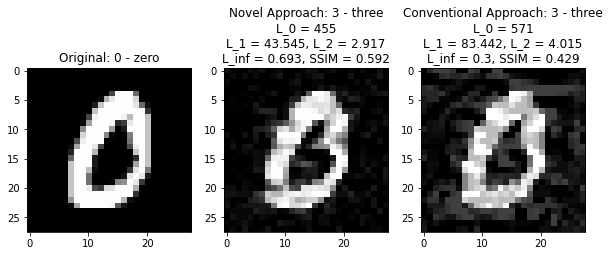

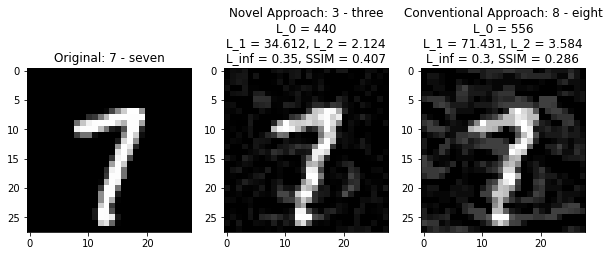

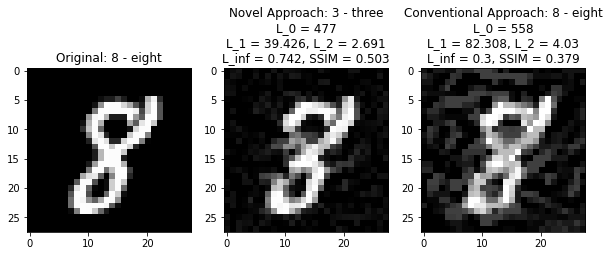

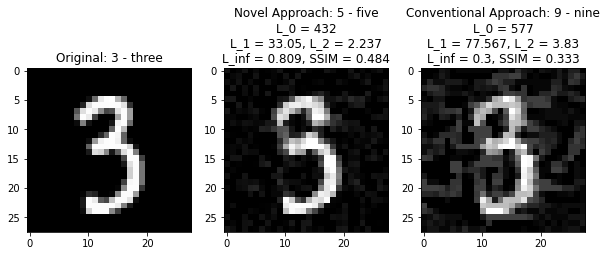

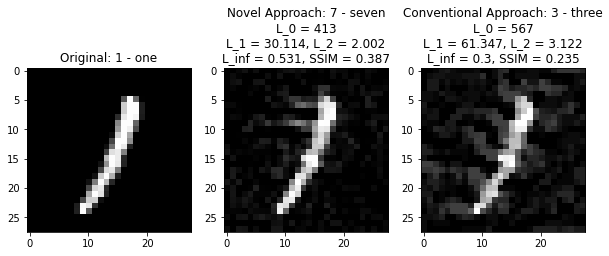

Total Image Count: 100 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.97
Total Image Count: 105 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9714285714285714
Total Image Count: 110 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9727272727272728
Total Image Count: 115 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9739130434782609
Total Image Count: 120 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.975
Total Image Count: 125 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.976
Total Image Count: 130 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9769230769230769
Total Image Count: 135 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9703703703703703
Total Image Count: 140 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9714285714285714
Total Image Count: 145 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9724137931034482


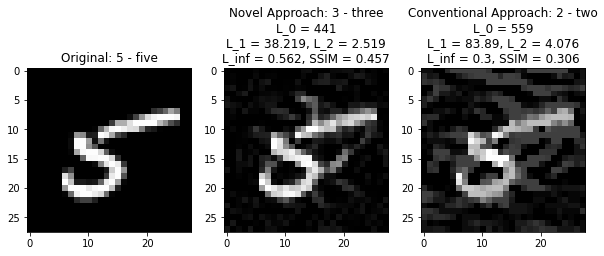

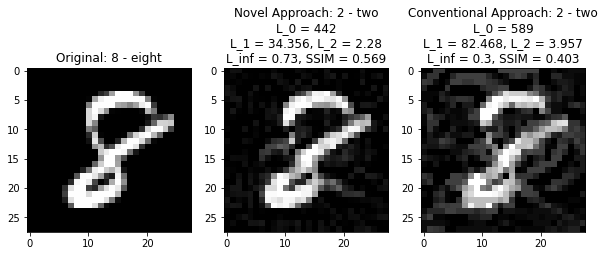

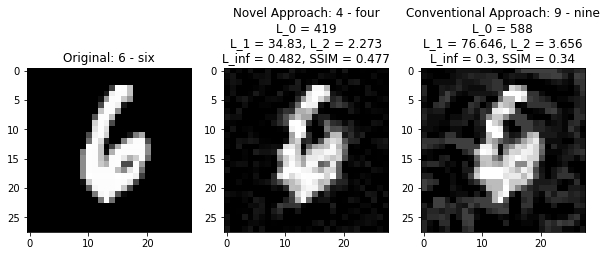

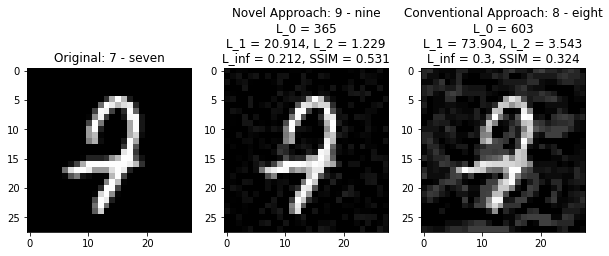

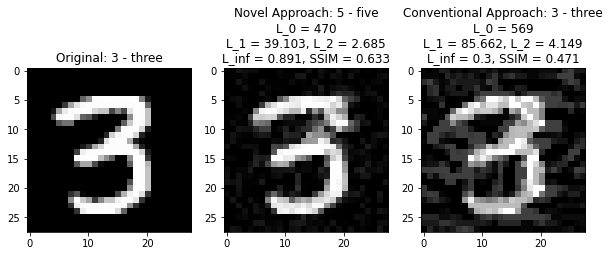

Total Image Count: 150 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9666666666666667
Total Image Count: 155 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.967741935483871
Total Image Count: 160 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.96875
Total Image Count: 165 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9696969696969697
Total Image Count: 170 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9705882352941176
Total Image Count: 175 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9714285714285714
Total Image Count: 180 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9722222222222222
Total Image Count: 185 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.972972972972973
Total Image Count: 190 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9736842105263158
Total Image Count: 195 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9743589743589743


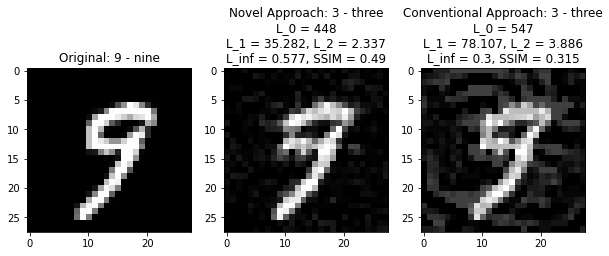

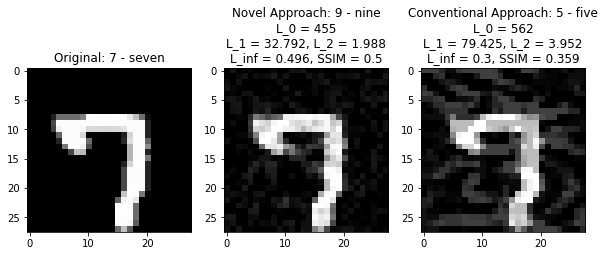

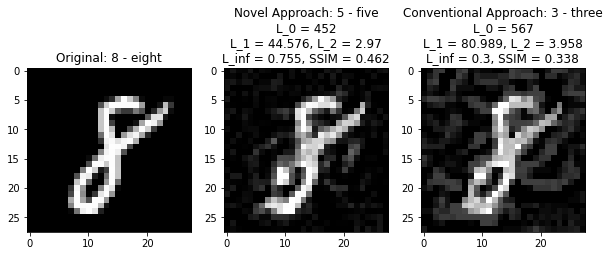

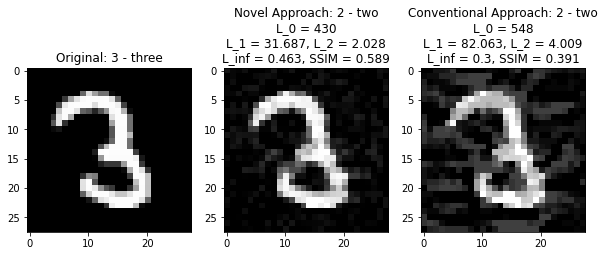

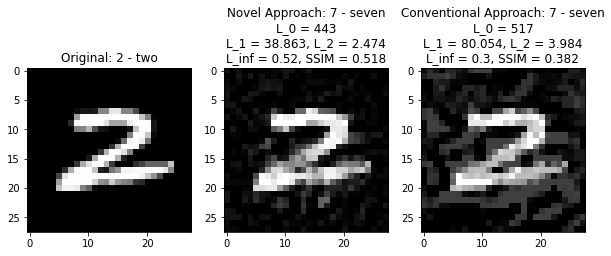

Total Image Count: 200 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.975
Total Image Count: 205 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9707317073170731
Total Image Count: 210 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9714285714285714
Total Image Count: 215 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9720930232558139
Total Image Count: 220 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9681818181818181
Total Image Count: 225 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9644444444444444
Total Image Count: 230 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9652173913043478
Total Image Count: 235 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9659574468085106
Total Image Count: 240 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9666666666666667
Total Image Count: 245 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9673469387755103


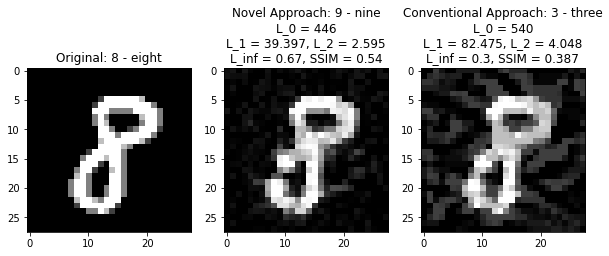

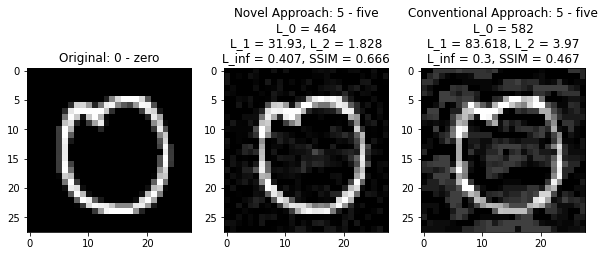

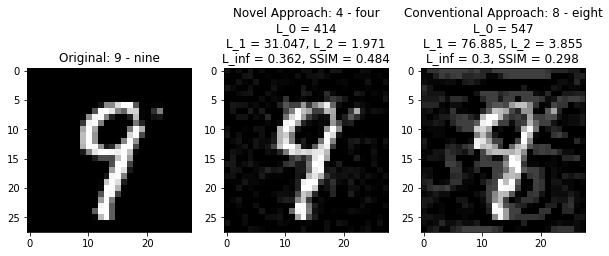

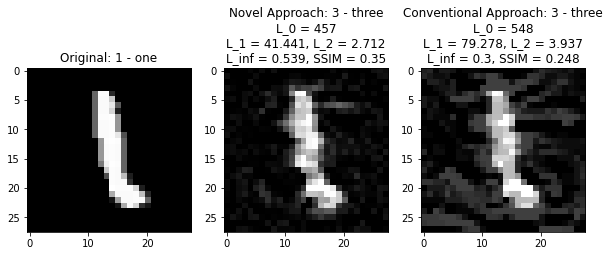

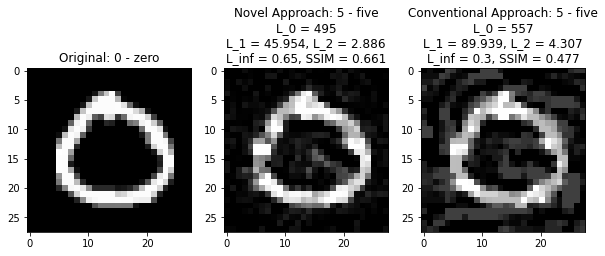

Total Image Count: 250 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.968
Total Image Count: 255 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9686274509803922
Total Image Count: 260 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9692307692307692
Total Image Count: 265 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.969811320754717
Total Image Count: 270 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9703703703703703
Total Image Count: 275 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9709090909090909
Total Image Count: 280 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9678571428571429
Total Image Count: 285 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9649122807017544
Total Image Count: 290 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9655172413793104
Total Image Count: 295 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9627118644067797


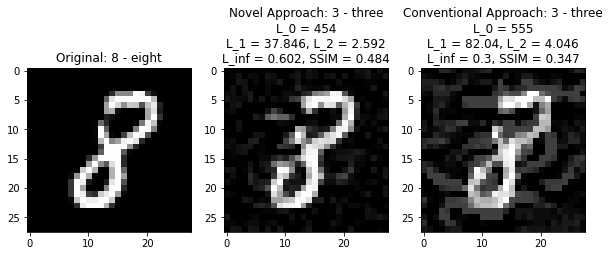

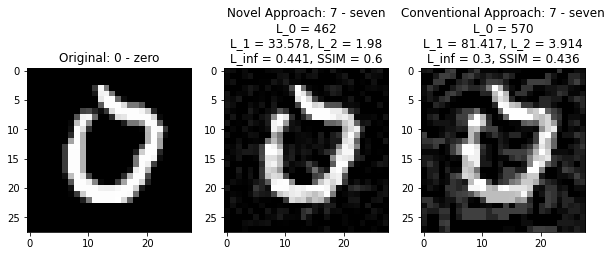

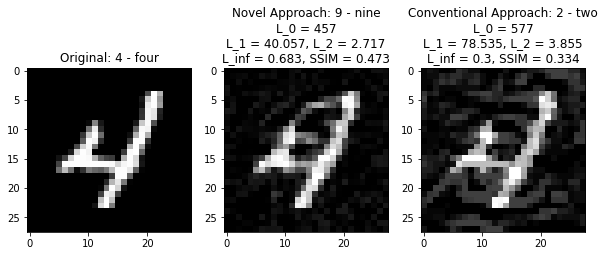

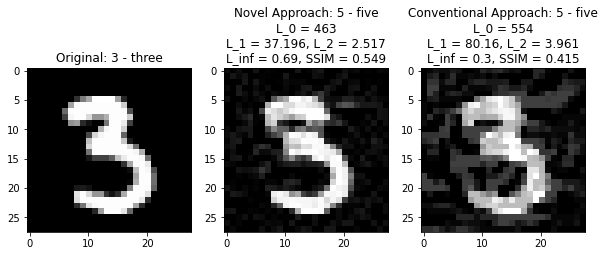

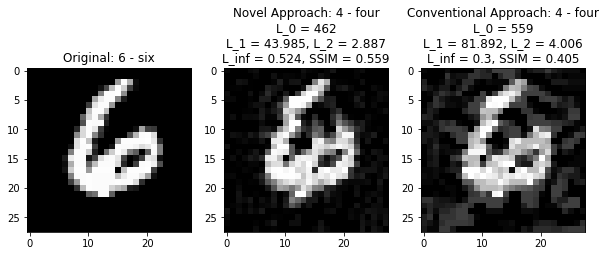

Total Image Count: 300 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9633333333333334
Total Image Count: 305 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9639344262295082
Total Image Count: 310 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.964516129032258
Total Image Count: 315 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9650793650793651
Total Image Count: 320 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.965625
Total Image Count: 325 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9661538461538461
Total Image Count: 330 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9666666666666667
Total Image Count: 335 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9671641791044776
Total Image Count: 340 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9676470588235294
Total Image Count: 345 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9681159420289855


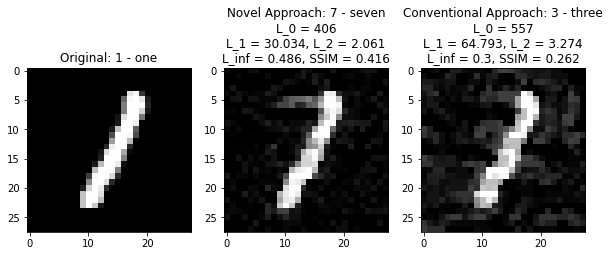

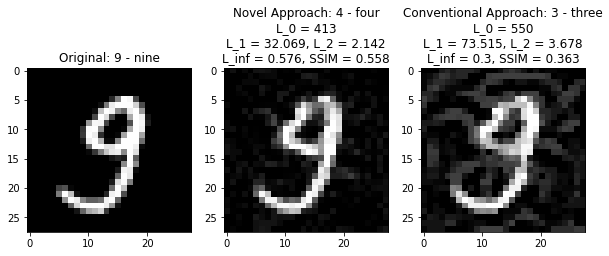

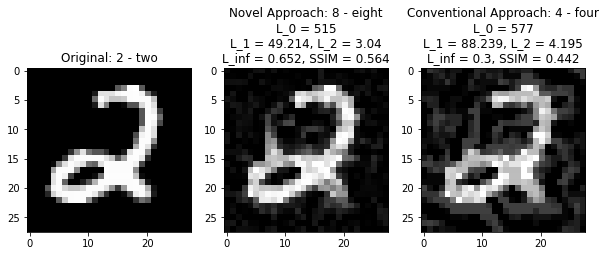

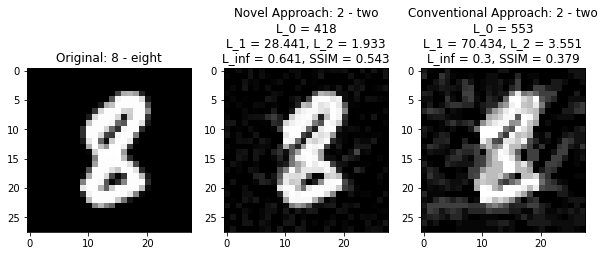

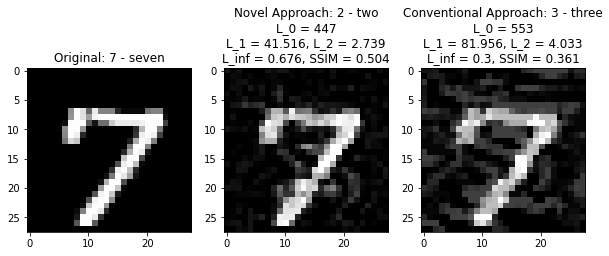

Total Image Count: 350 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9685714285714285
Total Image Count: 355 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9690140845070423
Total Image Count: 360 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9694444444444444
Total Image Count: 365 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9698630136986301
Total Image Count: 370 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9702702702702702
Total Image Count: 375 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9706666666666667
Total Image Count: 380 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9710526315789474
Total Image Count: 385 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9714285714285714
Total Image Count: 390 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9717948717948718
Total Image Count: 395 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9721518987341772


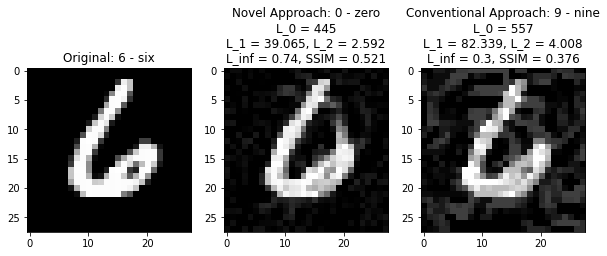

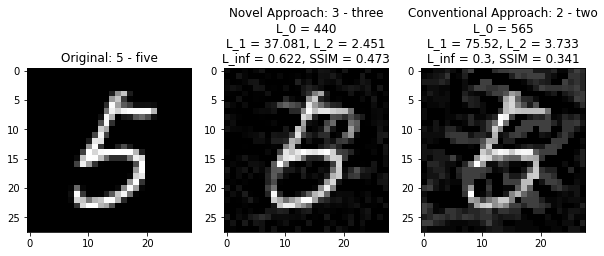

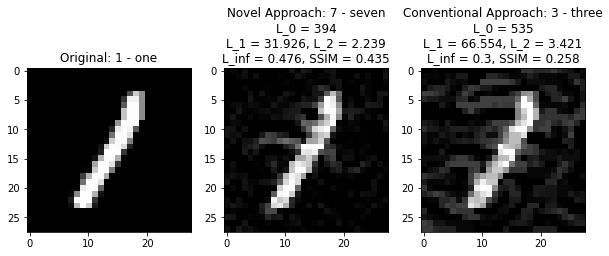

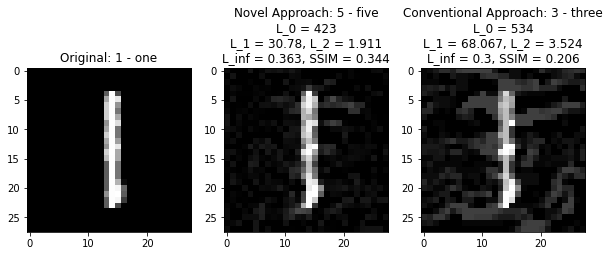

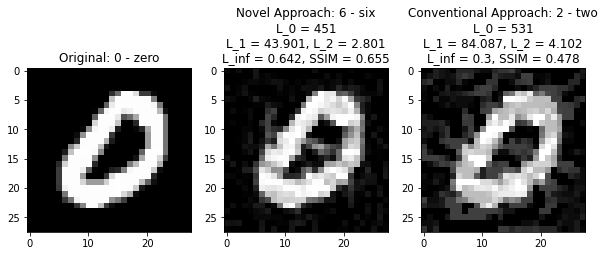

Total Image Count: 400 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9725
Total Image Count: 405 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9728395061728395
Total Image Count: 410 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.973170731707317
Total Image Count: 415 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9734939759036144
Total Image Count: 420 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9738095238095238
Total Image Count: 425 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9741176470588235
Total Image Count: 430 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9744186046511628
Total Image Count: 435 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9747126436781609
Total Image Count: 440 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.975
Total Image Count: 445 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9752808988764045


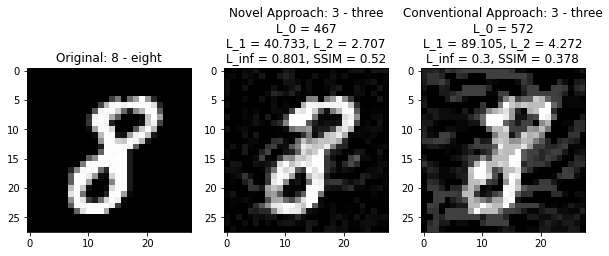

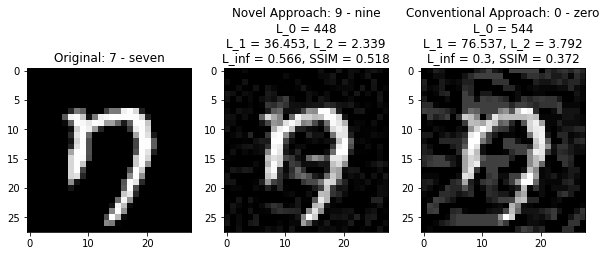

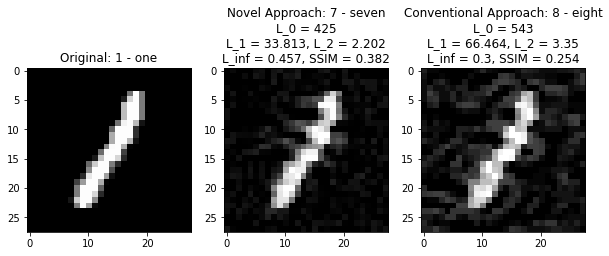

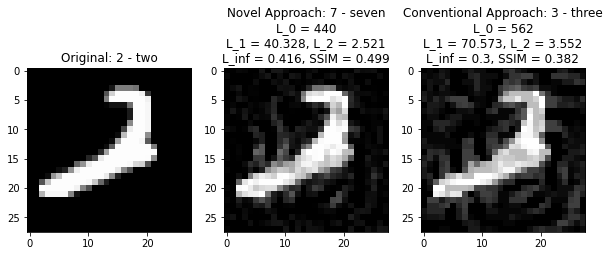

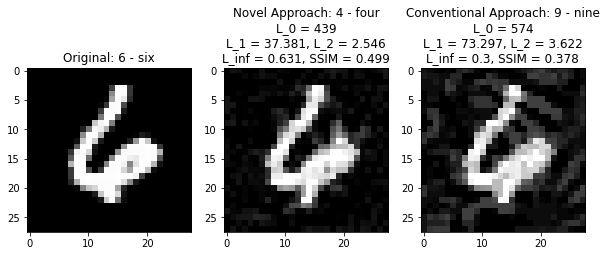

Total Image Count: 450 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9755555555555555
Total Image Count: 455 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9758241758241758
Total Image Count: 460 Success Rate:
 Novel Approach: 1.0 Conventional Approach: 0.9760869565217392
Total Image Count: 465 Success Rate:
 Novel Approach: 0.9978494623655914 Conventional Approach: 0.9763440860215054
Total Image Count: 470 Success Rate:
 Novel Approach: 0.997872340425532 Conventional Approach: 0.9765957446808511
Total Image Count: 475 Success Rate:
 Novel Approach: 0.9957894736842106 Conventional Approach: 0.9768421052631578
Total Image Count: 480 Success Rate:
 Novel Approach: 0.9958333333333333 Conventional Approach: 0.9770833333333333
Total Image Count: 485 Success Rate:
 Novel Approach: 0.9958762886597938 Conventional Approach: 0.977319587628866
Total Image Count: 490 Success Rate:
 Novel Approach: 0.9959183673469387 Conventional Approach: 0.9775510204081632
Total Image 

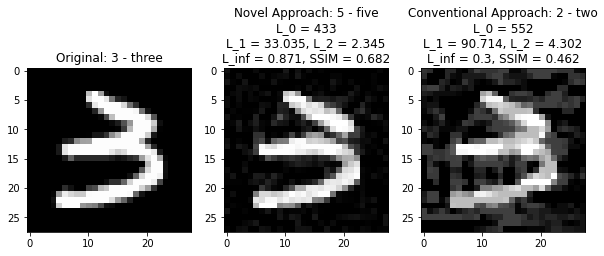

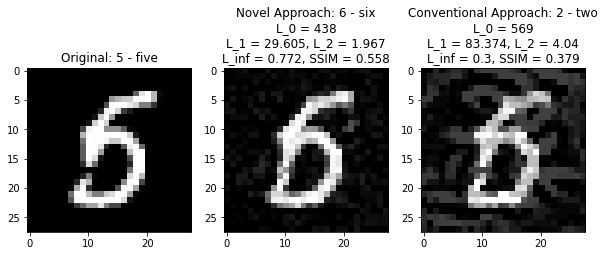

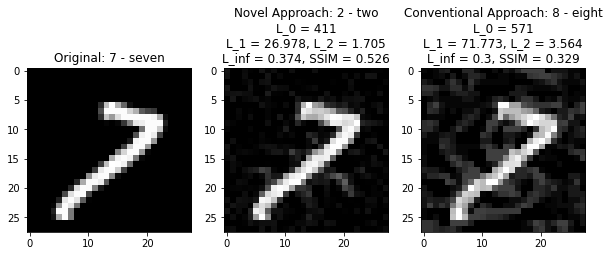

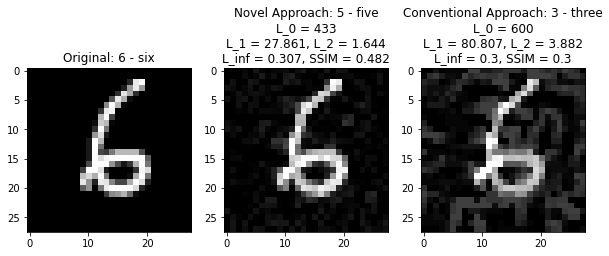

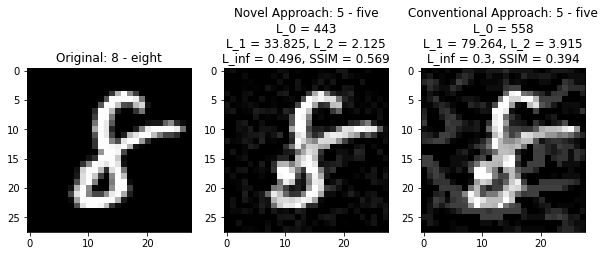

Total Image Count: 500 Success Rate:
 Novel Approach: 0.996 Conventional Approach: 0.978
Total Image Count: 505 Success Rate:
 Novel Approach: 0.996039603960396 Conventional Approach: 0.9782178217821782
Total Image Count: 510 Success Rate:
 Novel Approach: 0.996078431372549 Conventional Approach: 0.9784313725490196
Total Image Count: 515 Success Rate:
 Novel Approach: 0.996116504854369 Conventional Approach: 0.9786407766990292
Total Image Count: 520 Success Rate:
 Novel Approach: 0.9961538461538462 Conventional Approach: 0.9788461538461538
Total Image Count: 525 Success Rate:
 Novel Approach: 0.9961904761904762 Conventional Approach: 0.979047619047619
Total Image Count: 530 Success Rate:
 Novel Approach: 0.9943396226415094 Conventional Approach: 0.9773584905660377
Total Image Count: 535 Success Rate:
 Novel Approach: 0.994392523364486 Conventional Approach: 0.9775700934579439
Total Image Count: 540 Success Rate:
 Novel Approach: 0.9944444444444445 Conventional Approach: 0.9777777777777

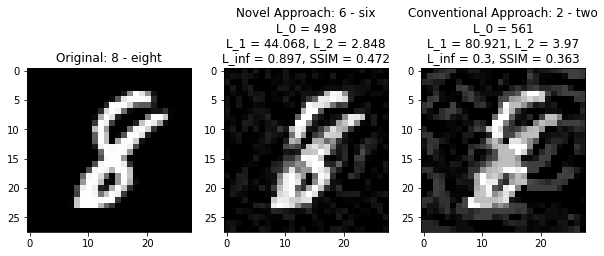

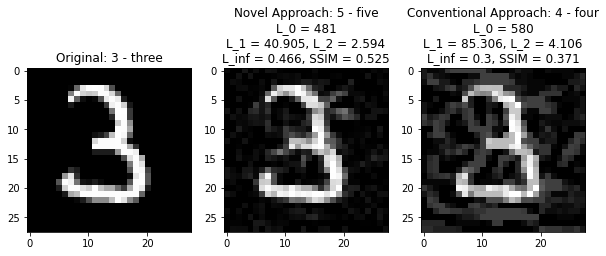

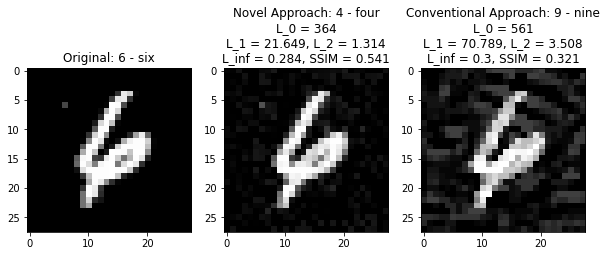

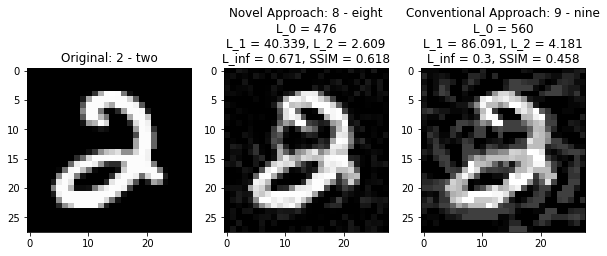

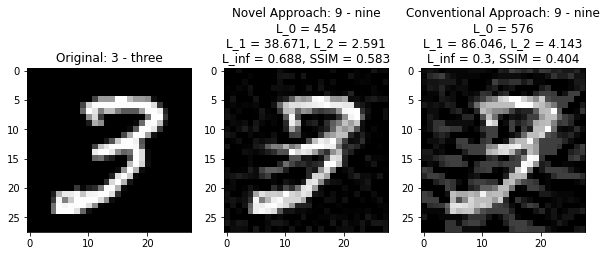

Total Image Count: 550 Success Rate:
 Novel Approach: 0.9945454545454545 Conventional Approach: 0.9781818181818182
Total Image Count: 555 Success Rate:
 Novel Approach: 0.9945945945945946 Conventional Approach: 0.9783783783783784
Total Image Count: 560 Success Rate:
 Novel Approach: 0.9946428571428572 Conventional Approach: 0.9785714285714285
Total Image Count: 565 Success Rate:
 Novel Approach: 0.9946902654867257 Conventional Approach: 0.9787610619469026
Total Image Count: 570 Success Rate:
 Novel Approach: 0.9947368421052631 Conventional Approach: 0.9789473684210527
Total Image Count: 575 Success Rate:
 Novel Approach: 0.9947826086956522 Conventional Approach: 0.9791304347826087
Total Image Count: 580 Success Rate:
 Novel Approach: 0.9948275862068966 Conventional Approach: 0.9793103448275862
Total Image Count: 585 Success Rate:
 Novel Approach: 0.9948717948717949 Conventional Approach: 0.9794871794871794
Total Image Count: 590 Success Rate:
 Novel Approach: 0.9949152542372881 Convent

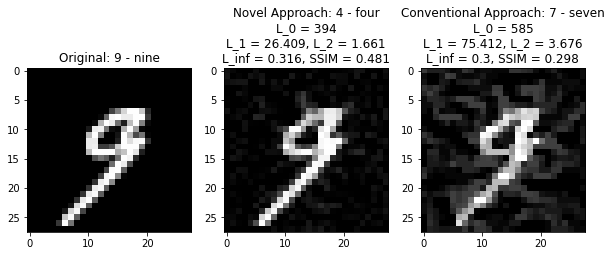

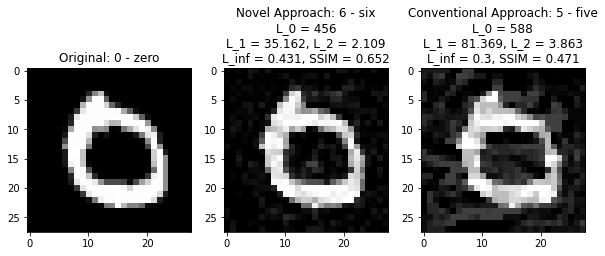

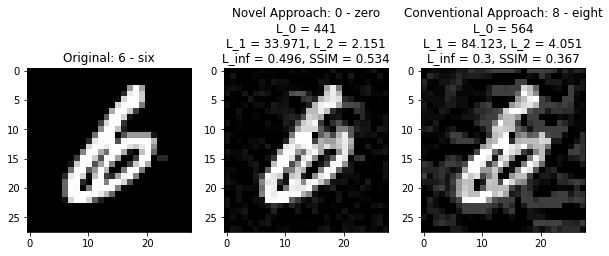

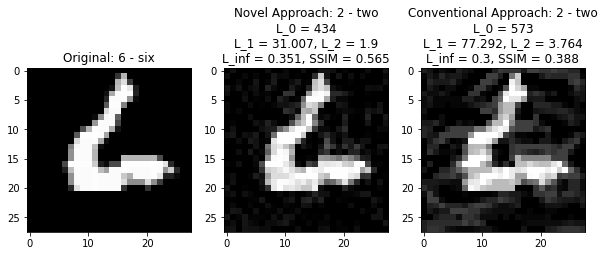

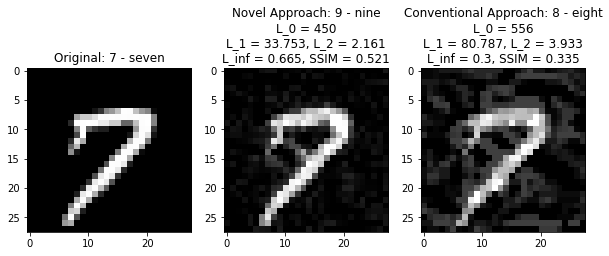

Total Image Count: 600 Success Rate:
 Novel Approach: 0.995 Conventional Approach: 0.98
Total Image Count: 605 Success Rate:
 Novel Approach: 0.9950413223140496 Conventional Approach: 0.9801652892561984
Total Image Count: 610 Success Rate:
 Novel Approach: 0.9950819672131147 Conventional Approach: 0.980327868852459
Total Image Count: 615 Success Rate:
 Novel Approach: 0.9951219512195122 Conventional Approach: 0.9804878048780488
Total Image Count: 620 Success Rate:
 Novel Approach: 0.9951612903225806 Conventional Approach: 0.9806451612903225
Total Image Count: 625 Success Rate:
 Novel Approach: 0.9952 Conventional Approach: 0.9808
Total Image Count: 630 Success Rate:
 Novel Approach: 0.9952380952380953 Conventional Approach: 0.9809523809523809
Total Image Count: 635 Success Rate:
 Novel Approach: 0.9952755905511811 Conventional Approach: 0.9795275590551181
Total Image Count: 640 Success Rate:
 Novel Approach: 0.9953125 Conventional Approach: 0.9796875
Total Image Count: 645 Success Rate

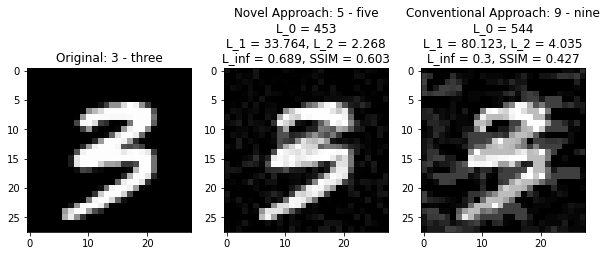

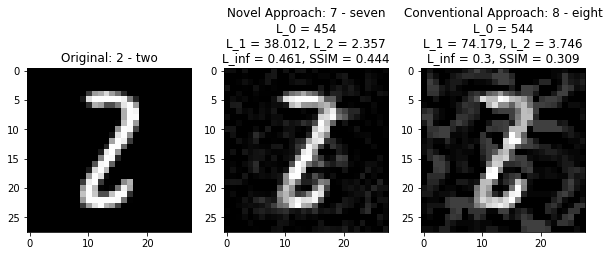

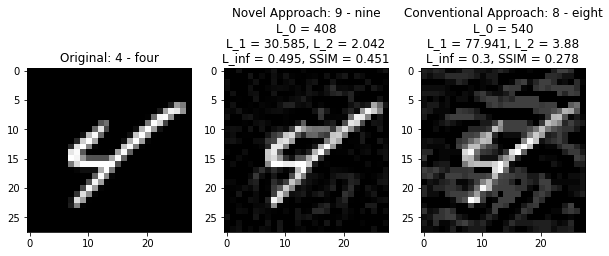

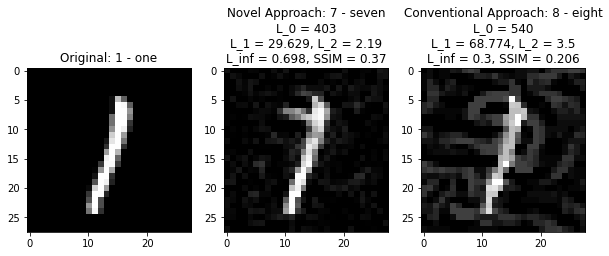

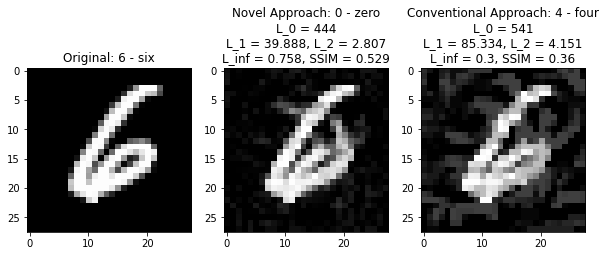

Total Image Count: 650 Success Rate:
 Novel Approach: 0.9953846153846154 Conventional Approach: 0.98
Total Image Count: 655 Success Rate:
 Novel Approach: 0.9954198473282443 Conventional Approach: 0.9801526717557252
Total Image Count: 660 Success Rate:
 Novel Approach: 0.9954545454545455 Conventional Approach: 0.9803030303030303
Total Image Count: 665 Success Rate:
 Novel Approach: 0.9954887218045113 Conventional Approach: 0.9804511278195489
Total Image Count: 670 Success Rate:
 Novel Approach: 0.9955223880597015 Conventional Approach: 0.9805970149253731
Total Image Count: 675 Success Rate:
 Novel Approach: 0.9955555555555555 Conventional Approach: 0.9807407407407407
Total Image Count: 680 Success Rate:
 Novel Approach: 0.9955882352941177 Conventional Approach: 0.9808823529411764
Total Image Count: 685 Success Rate:
 Novel Approach: 0.9956204379562044 Conventional Approach: 0.981021897810219
Total Image Count: 690 Success Rate:
 Novel Approach: 0.9956521739130435 Conventional Approach:

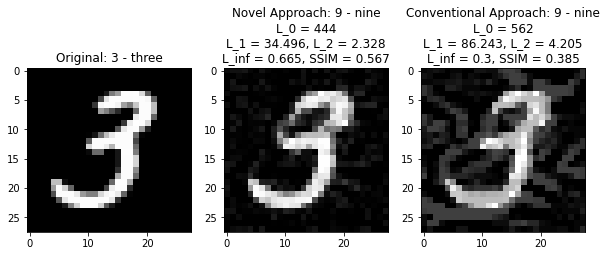

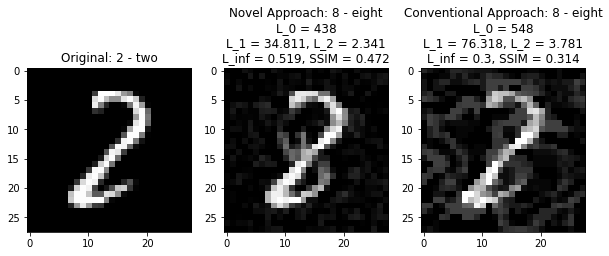

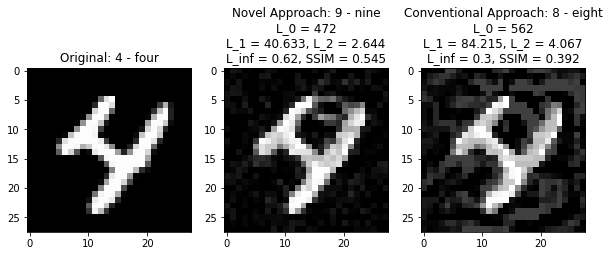

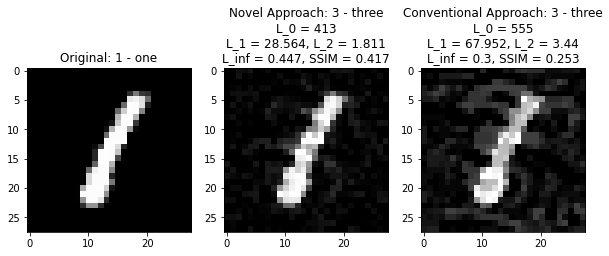

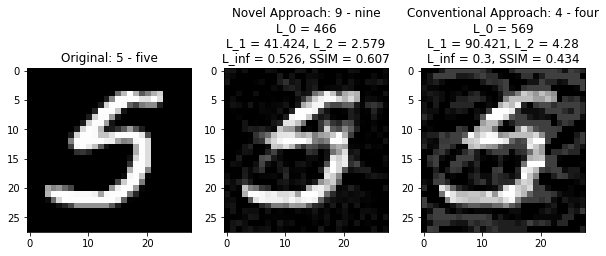

Total Image Count: 700 Success Rate:
 Novel Approach: 0.9957142857142857 Conventional Approach: 0.9814285714285714
Total Image Count: 705 Success Rate:
 Novel Approach: 0.9957446808510638 Conventional Approach: 0.9815602836879432
Total Image Count: 710 Success Rate:
 Novel Approach: 0.995774647887324 Conventional Approach: 0.9816901408450704
Total Image Count: 715 Success Rate:
 Novel Approach: 0.9958041958041958 Conventional Approach: 0.9818181818181818
Total Image Count: 720 Success Rate:
 Novel Approach: 0.9958333333333333 Conventional Approach: 0.9819444444444444
Total Image Count: 725 Success Rate:
 Novel Approach: 0.9958620689655172 Conventional Approach: 0.9820689655172414
Total Image Count: 730 Success Rate:
 Novel Approach: 0.9958904109589041 Conventional Approach: 0.9821917808219178
Total Image Count: 735 Success Rate:
 Novel Approach: 0.9959183673469387 Conventional Approach: 0.9823129251700681
Total Image Count: 740 Success Rate:
 Novel Approach: 0.995945945945946 Conventio

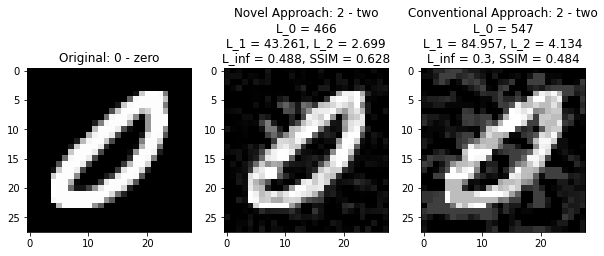

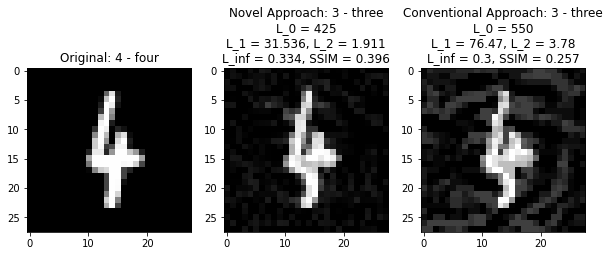

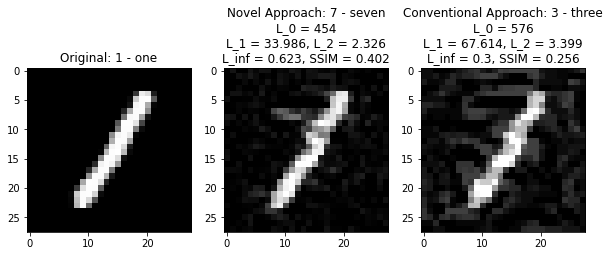

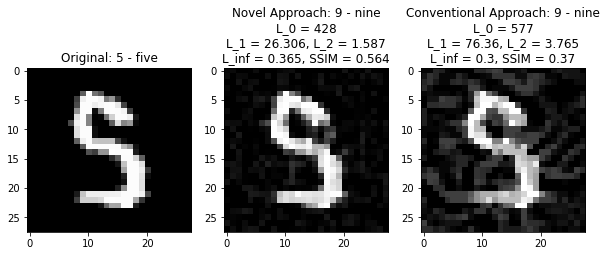

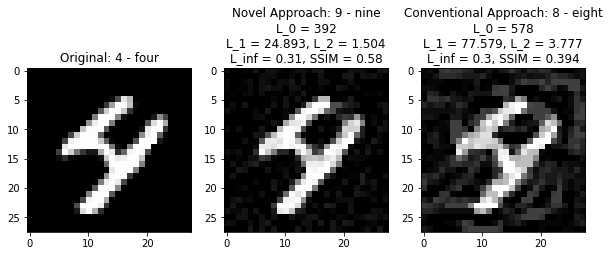

Total Image Count: 750 Success Rate:
 Novel Approach: 0.996 Conventional Approach: 0.9826666666666667
Total Image Count: 755 Success Rate:
 Novel Approach: 0.9960264900662251 Conventional Approach: 0.9827814569536424
Total Image Count: 760 Success Rate:
 Novel Approach: 0.9960526315789474 Conventional Approach: 0.9828947368421053
Total Image Count: 765 Success Rate:
 Novel Approach: 0.996078431372549 Conventional Approach: 0.9830065359477124
Total Image Count: 770 Success Rate:
 Novel Approach: 0.9961038961038962 Conventional Approach: 0.9831168831168832
Total Image Count: 775 Success Rate:
 Novel Approach: 0.9961290322580645 Conventional Approach: 0.983225806451613
Total Image Count: 780 Success Rate:
 Novel Approach: 0.9961538461538462 Conventional Approach: 0.982051282051282
Total Image Count: 785 Success Rate:
 Novel Approach: 0.9961783439490446 Conventional Approach: 0.9821656050955414
Total Image Count: 790 Success Rate:
 Novel Approach: 0.9962025316455696 Conventional Approach: 

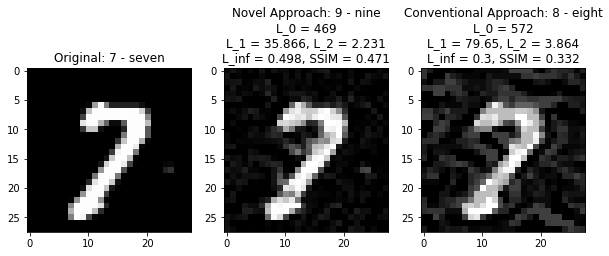

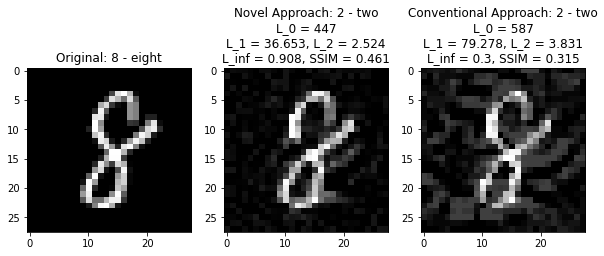

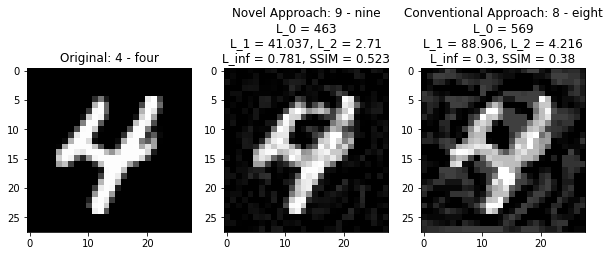

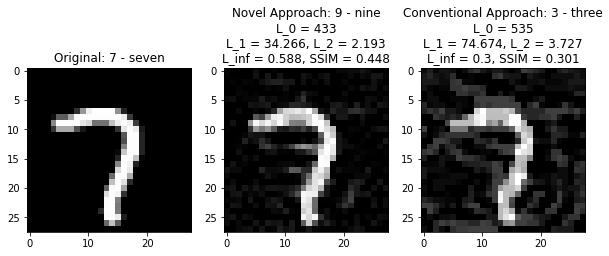

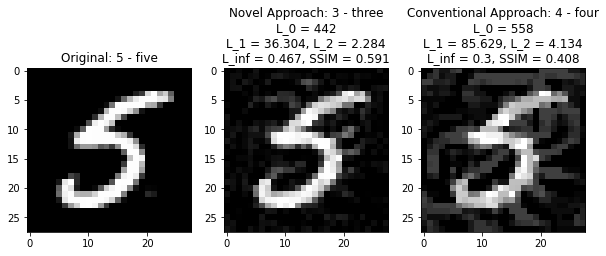

Total Image Count: 800 Success Rate:
 Novel Approach: 0.99625 Conventional Approach: 0.98
Total Image Count: 805 Success Rate:
 Novel Approach: 0.9962732919254659 Conventional Approach: 0.9801242236024845
Total Image Count: 810 Success Rate:
 Novel Approach: 0.9962962962962963 Conventional Approach: 0.980246913580247
Total Image Count: 815 Success Rate:
 Novel Approach: 0.996319018404908 Conventional Approach: 0.9803680981595092
Total Image Count: 820 Success Rate:
 Novel Approach: 0.9963414634146341 Conventional Approach: 0.9804878048780488
Total Image Count: 825 Success Rate:
 Novel Approach: 0.9963636363636363 Conventional Approach: 0.9793939393939394
Total Image Count: 830 Success Rate:
 Novel Approach: 0.9963855421686747 Conventional Approach: 0.9783132530120482
Total Image Count: 835 Success Rate:
 Novel Approach: 0.9964071856287425 Conventional Approach: 0.9772455089820359
Total Image Count: 840 Success Rate:
 Novel Approach: 0.9964285714285714 Conventional Approach: 0.977380952

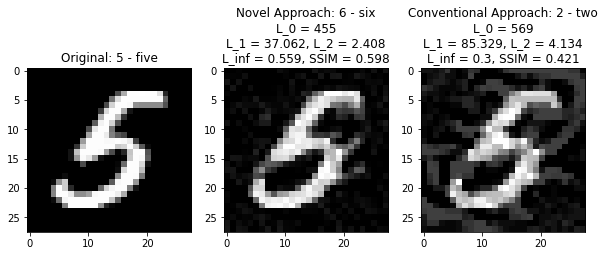

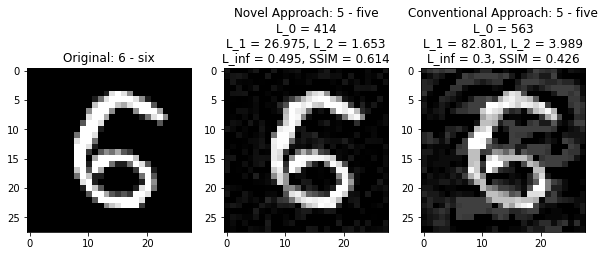

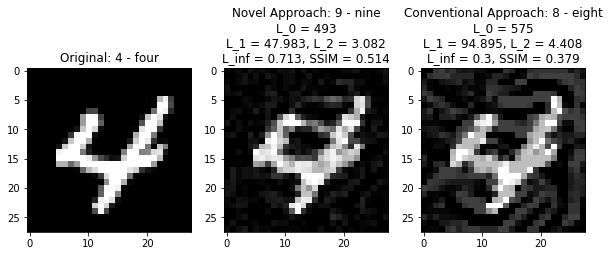

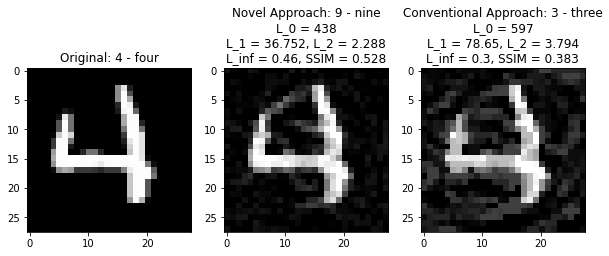

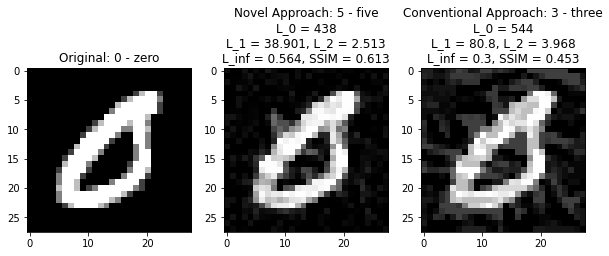

Total Image Count: 850 Success Rate:
 Novel Approach: 0.9964705882352941 Conventional Approach: 0.9764705882352941
Total Image Count: 855 Success Rate:
 Novel Approach: 0.9964912280701754 Conventional Approach: 0.9766081871345029
Total Image Count: 860 Success Rate:
 Novel Approach: 0.9965116279069768 Conventional Approach: 0.9767441860465116
Total Image Count: 865 Success Rate:
 Novel Approach: 0.9965317919075144 Conventional Approach: 0.976878612716763
Total Image Count: 870 Success Rate:
 Novel Approach: 0.996551724137931 Conventional Approach: 0.9770114942528736
Total Image Count: 875 Success Rate:
 Novel Approach: 0.9965714285714286 Conventional Approach: 0.9771428571428571
Total Image Count: 880 Success Rate:
 Novel Approach: 0.9965909090909091 Conventional Approach: 0.9761363636363637
Total Image Count: 885 Success Rate:
 Novel Approach: 0.9966101694915255 Conventional Approach: 0.976271186440678
Total Image Count: 890 Success Rate:
 Novel Approach: 0.996629213483146 Conventiona

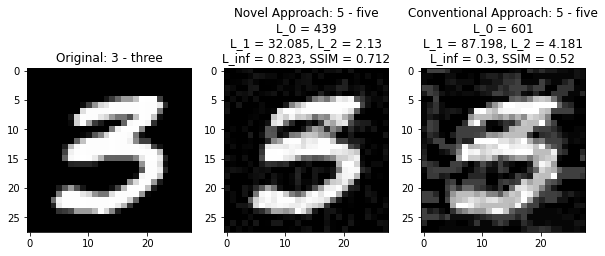

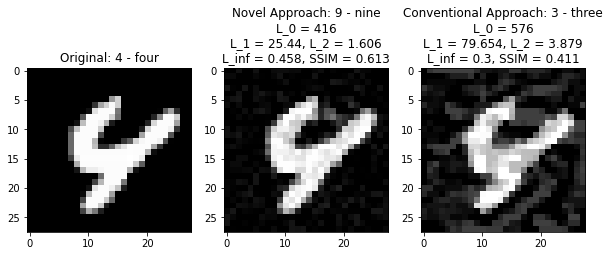

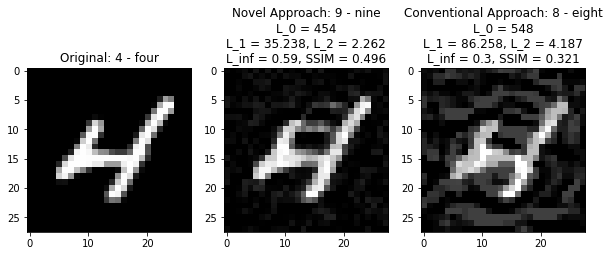

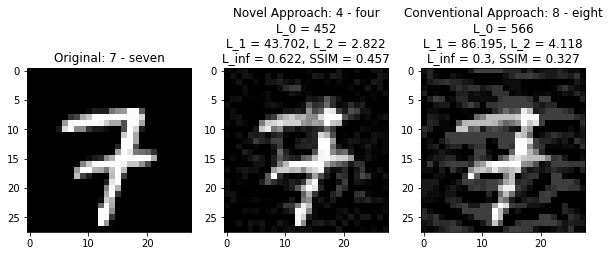

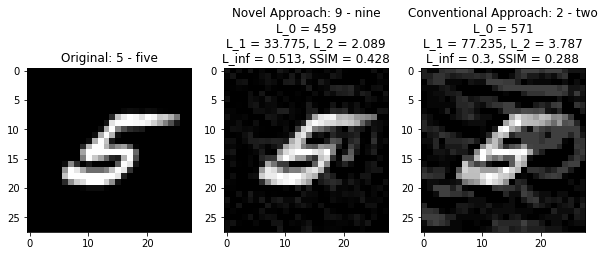

Total Image Count: 900 Success Rate:
 Novel Approach: 0.9966666666666667 Conventional Approach: 0.9766666666666667
Total Image Count: 905 Success Rate:
 Novel Approach: 0.9966850828729282 Conventional Approach: 0.9767955801104973
Total Image Count: 910 Success Rate:
 Novel Approach: 0.9967032967032967 Conventional Approach: 0.9769230769230769
Total Image Count: 915 Success Rate:
 Novel Approach: 0.9967213114754099 Conventional Approach: 0.9770491803278688
Total Image Count: 920 Success Rate:
 Novel Approach: 0.9967391304347826 Conventional Approach: 0.9771739130434782
Total Image Count: 925 Success Rate:
 Novel Approach: 0.9967567567567568 Conventional Approach: 0.9762162162162162
Total Image Count: 930 Success Rate:
 Novel Approach: 0.9967741935483871 Conventional Approach: 0.9763440860215054
Total Image Count: 935 Success Rate:
 Novel Approach: 0.9967914438502674 Conventional Approach: 0.9764705882352941
Total Image Count: 940 Success Rate:
 Novel Approach: 0.9968085106382979 Convent

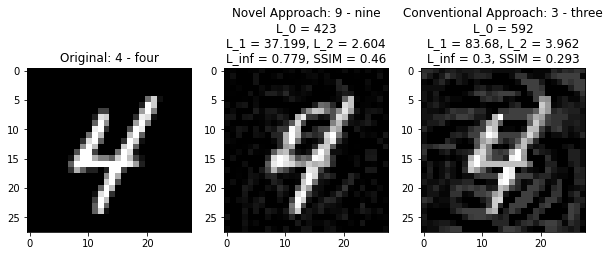

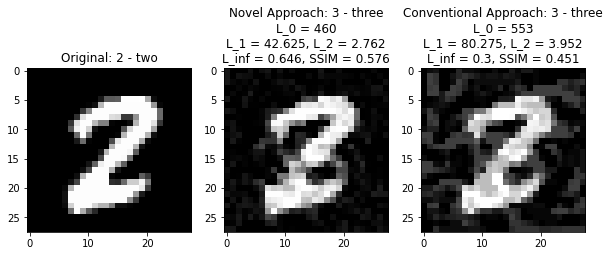

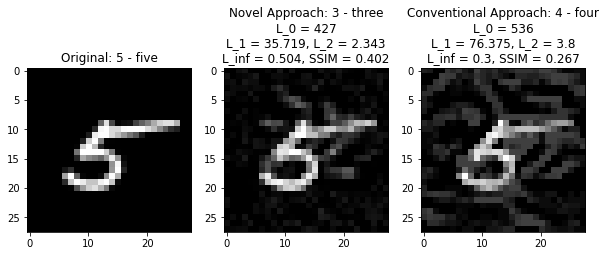

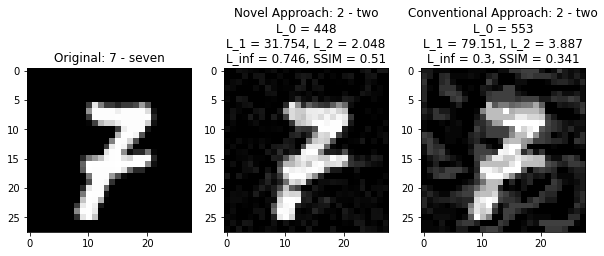

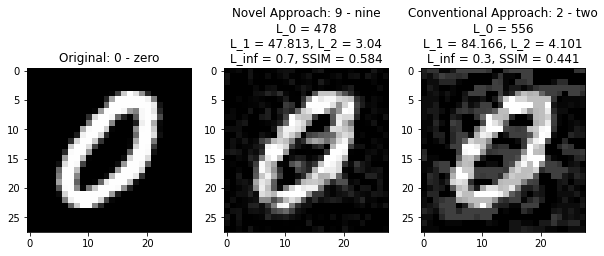

Total Image Count: 950 Success Rate:
 Novel Approach: 0.9968421052631579 Conventional Approach: 0.9768421052631578
Total Image Count: 955 Success Rate:
 Novel Approach: 0.9968586387434555 Conventional Approach: 0.9769633507853404
Total Image Count: 960 Success Rate:
 Novel Approach: 0.996875 Conventional Approach: 0.9770833333333333
Total Image Count: 965 Success Rate:
 Novel Approach: 0.9968911917098445 Conventional Approach: 0.9761658031088083
Total Image Count: 970 Success Rate:
 Novel Approach: 0.9969072164948454 Conventional Approach: 0.9762886597938144
Total Image Count: 975 Success Rate:
 Novel Approach: 0.9969230769230769 Conventional Approach: 0.9764102564102564
Total Image Count: 980 Success Rate:
 Novel Approach: 0.996938775510204 Conventional Approach: 0.9755102040816327
Total Image Count: 985 Success Rate:
 Novel Approach: 0.9969543147208122 Conventional Approach: 0.9756345177664975
Total Image Count: 990 Success Rate:
 Novel Approach: 0.996969696969697 Conventional Approa

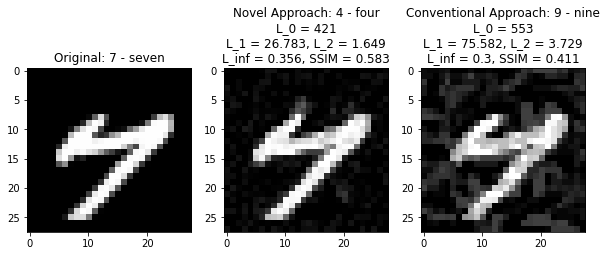

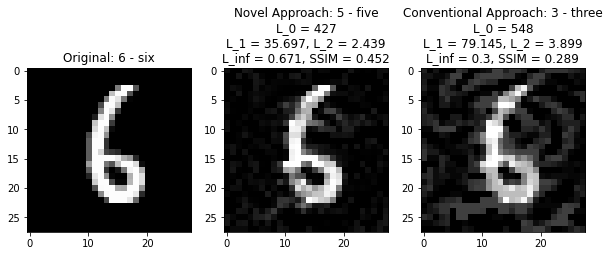

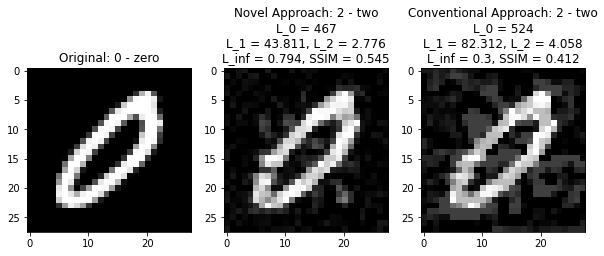

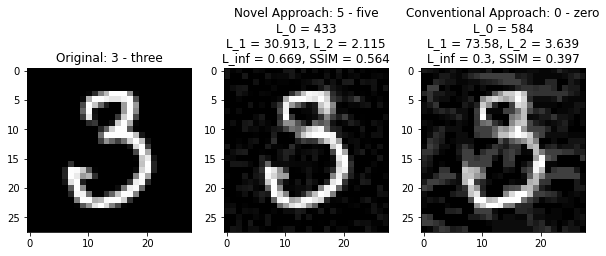

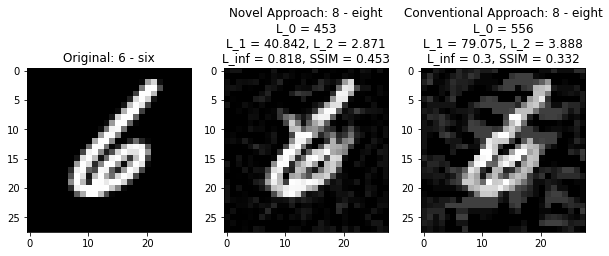

Total Image Count: 1000 Success Rate:
 Novel Approach: 0.997 Conventional Approach: 0.976
Total Image Count: 1005 Success Rate:
 Novel Approach: 0.9970149253731343 Conventional Approach: 0.9761194029850746
Total Image Count: 1010 Success Rate:
 Novel Approach: 0.997029702970297 Conventional Approach: 0.9762376237623762
Total Image Count: 1015 Success Rate:
 Novel Approach: 0.9970443349753695 Conventional Approach: 0.9763546798029556
Total Image Count: 1020 Success Rate:
 Novel Approach: 0.9970588235294118 Conventional Approach: 0.9764705882352941
Total Image Count: 1025 Success Rate:
 Novel Approach: 0.9970731707317073 Conventional Approach: 0.9765853658536585
Total Image Count: 1030 Success Rate:
 Novel Approach: 0.9970873786407767 Conventional Approach: 0.9766990291262136
Total Image Count: 1035 Success Rate:
 Novel Approach: 0.9971014492753624 Conventional Approach: 0.9768115942028985
Total Image Count: 1040 Success Rate:
 Novel Approach: 0.9971153846153846 Conventional Approach: 0.

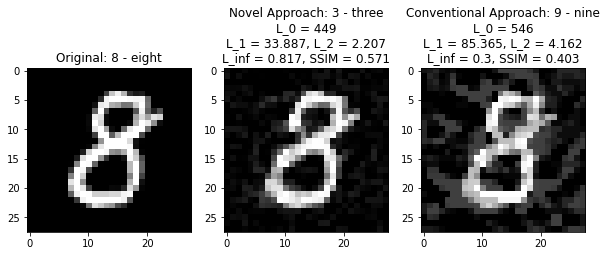

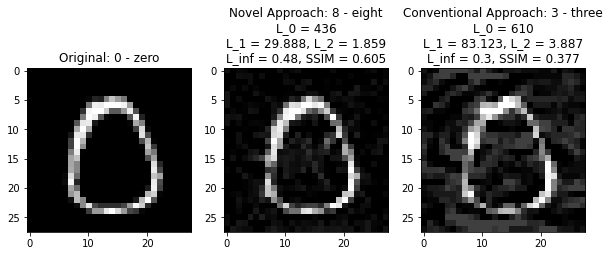

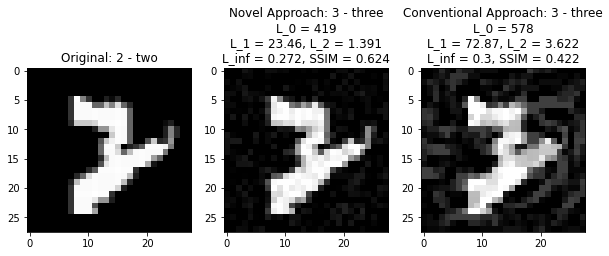

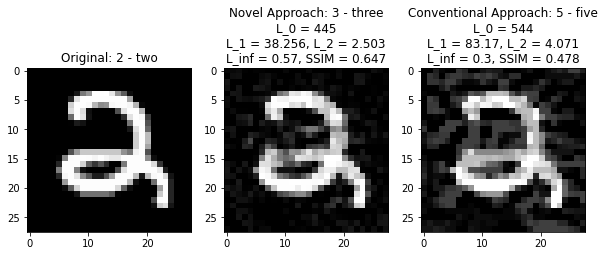

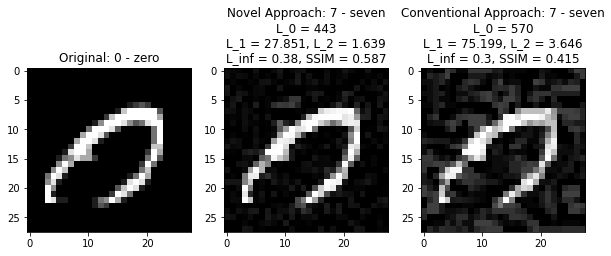

Total Image Count: 1050 Success Rate:
 Novel Approach: 0.9971428571428571 Conventional Approach: 0.9771428571428571
Total Image Count: 1055 Success Rate:
 Novel Approach: 0.9971563981042654 Conventional Approach: 0.9772511848341232
Total Image Count: 1060 Success Rate:
 Novel Approach: 0.9971698113207547 Conventional Approach: 0.9773584905660377
Total Image Count: 1065 Success Rate:
 Novel Approach: 0.9971830985915493 Conventional Approach: 0.9774647887323944
Total Image Count: 1070 Success Rate:
 Novel Approach: 0.997196261682243 Conventional Approach: 0.9775700934579439
Total Image Count: 1075 Success Rate:
 Novel Approach: 0.9972093023255814 Conventional Approach: 0.9776744186046512
Total Image Count: 1080 Success Rate:
 Novel Approach: 0.9972222222222222 Conventional Approach: 0.9777777777777777
Total Image Count: 1085 Success Rate:
 Novel Approach: 0.9972350230414746 Conventional Approach: 0.9778801843317972
Total Image Count: 1090 Success Rate:
 Novel Approach: 0.9972477064220183

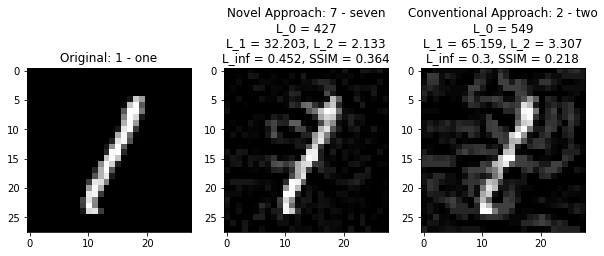

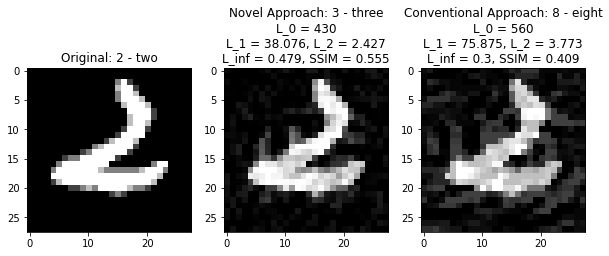

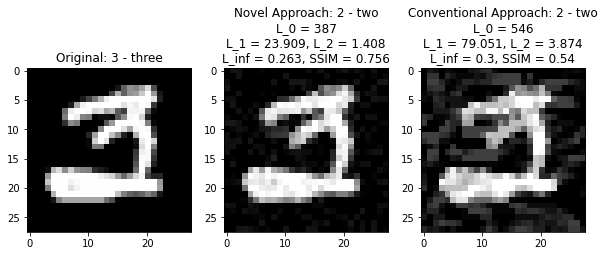

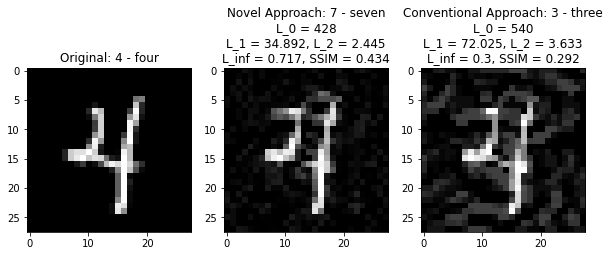

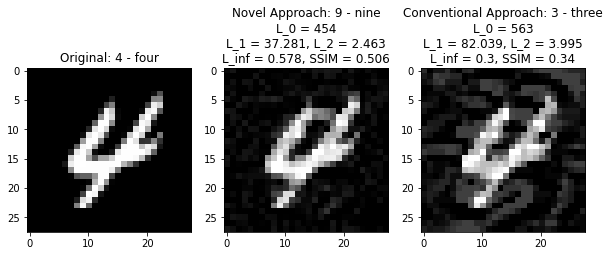

Total Image Count: 1100 Success Rate:
 Novel Approach: 0.9972727272727273 Conventional Approach: 0.9781818181818182
Total Image Count: 1105 Success Rate:
 Novel Approach: 0.9972850678733032 Conventional Approach: 0.9782805429864253
Total Image Count: 1110 Success Rate:
 Novel Approach: 0.9972972972972973 Conventional Approach: 0.9774774774774775
Total Image Count: 1115 Success Rate:
 Novel Approach: 0.9973094170403587 Conventional Approach: 0.9775784753363229
Total Image Count: 1120 Success Rate:
 Novel Approach: 0.9973214285714286 Conventional Approach: 0.9776785714285714
Total Image Count: 1125 Success Rate:
 Novel Approach: 0.9973333333333333 Conventional Approach: 0.9777777777777777
Total Image Count: 1130 Success Rate:
 Novel Approach: 0.9973451327433628 Conventional Approach: 0.9778761061946902
Total Image Count: 1135 Success Rate:
 Novel Approach: 0.9973568281938326 Conventional Approach: 0.9779735682819384
Total Image Count: 1140 Success Rate:
 Novel Approach: 0.997368421052631

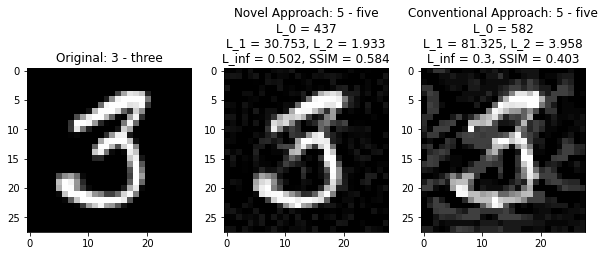

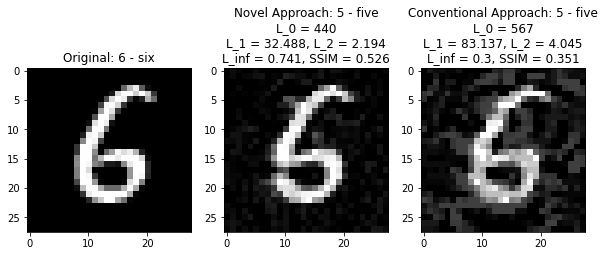

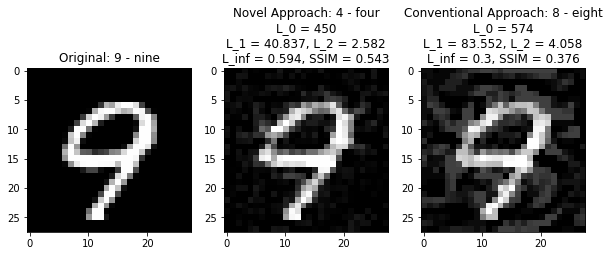

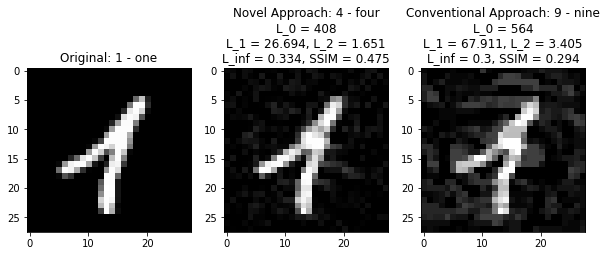

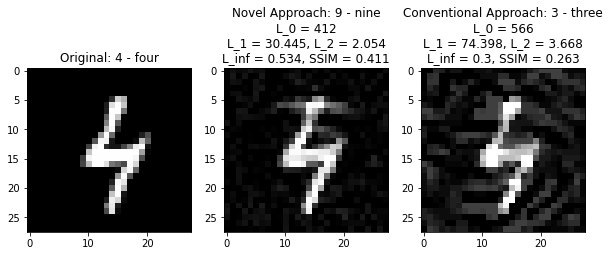

Total Image Count: 1150 Success Rate:
 Novel Approach: 0.9973913043478261 Conventional Approach: 0.9782608695652174
Total Image Count: 1155 Success Rate:
 Novel Approach: 0.9974025974025974 Conventional Approach: 0.9783549783549783
Total Image Count: 1160 Success Rate:
 Novel Approach: 0.9974137931034482 Conventional Approach: 0.978448275862069
Total Image Count: 1165 Success Rate:
 Novel Approach: 0.9974248927038627 Conventional Approach: 0.9785407725321889
Total Image Count: 1170 Success Rate:
 Novel Approach: 0.9974358974358974 Conventional Approach: 0.9786324786324786
Total Image Count: 1175 Success Rate:
 Novel Approach: 0.9974468085106383 Conventional Approach: 0.9787234042553191
Total Image Count: 1180 Success Rate:
 Novel Approach: 0.997457627118644 Conventional Approach: 0.9788135593220338
Total Image Count: 1185 Success Rate:
 Novel Approach: 0.9974683544303797 Conventional Approach: 0.9789029535864979
Total Image Count: 1190 Success Rate:
 Novel Approach: 0.9974789915966387 

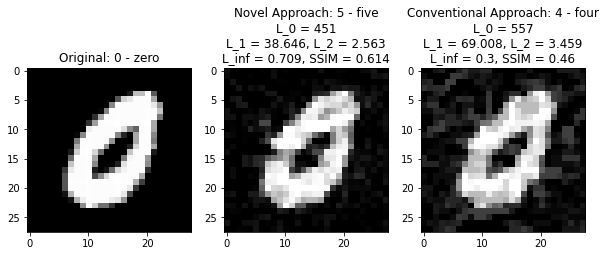

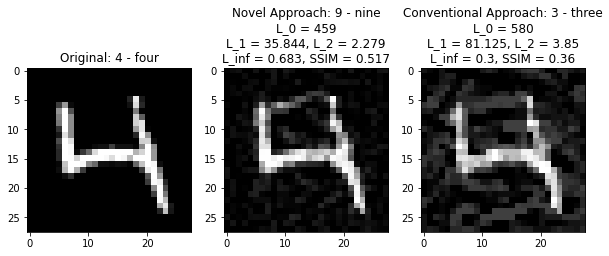

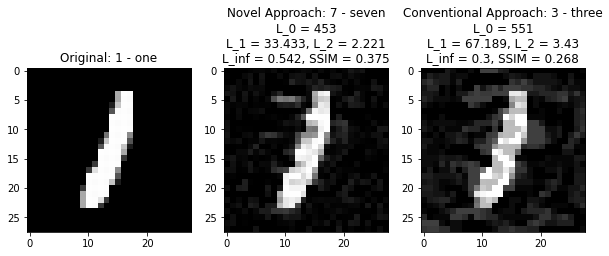

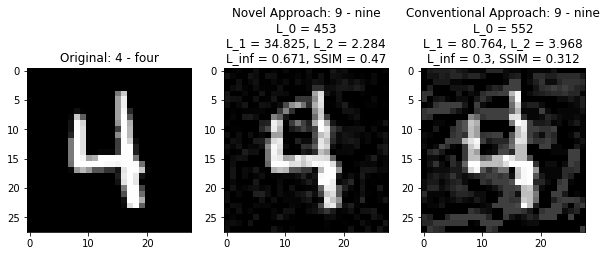

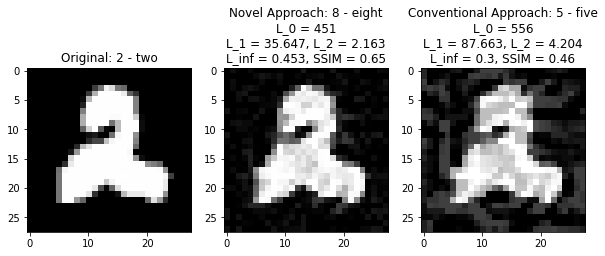

Total Image Count: 1200 Success Rate:
 Novel Approach: 0.9975 Conventional Approach: 0.9791666666666666
Total Image Count: 1205 Success Rate:
 Novel Approach: 0.9975103734439834 Conventional Approach: 0.979253112033195
Total Image Count: 1210 Success Rate:
 Novel Approach: 0.9975206611570248 Conventional Approach: 0.9793388429752066
Total Image Count: 1215 Success Rate:
 Novel Approach: 0.9975308641975309 Conventional Approach: 0.9794238683127572
Total Image Count: 1220 Success Rate:
 Novel Approach: 0.9975409836065574 Conventional Approach: 0.9795081967213115
Total Image Count: 1225 Success Rate:
 Novel Approach: 0.9975510204081632 Conventional Approach: 0.9795918367346939
Total Image Count: 1230 Success Rate:
 Novel Approach: 0.9975609756097561 Conventional Approach: 0.9796747967479674
Total Image Count: 1235 Success Rate:
 Novel Approach: 0.9975708502024292 Conventional Approach: 0.979757085020243
Total Image Count: 1240 Success Rate:
 Novel Approach: 0.9975806451612903 Conventional

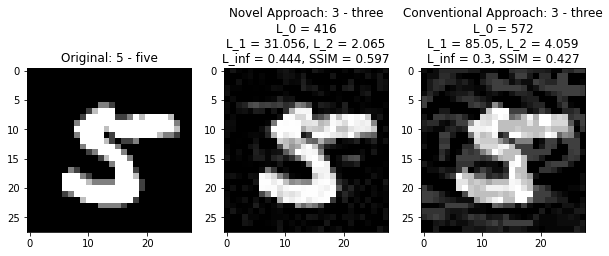

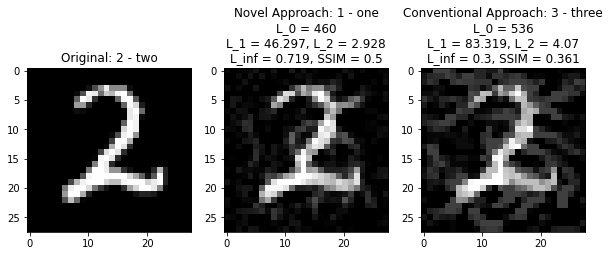

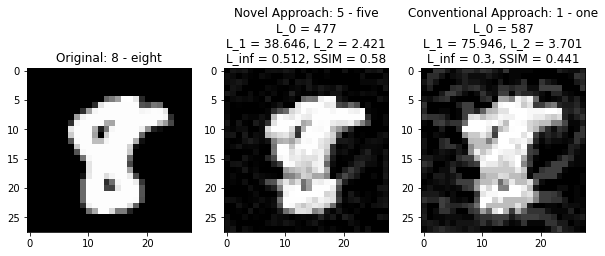

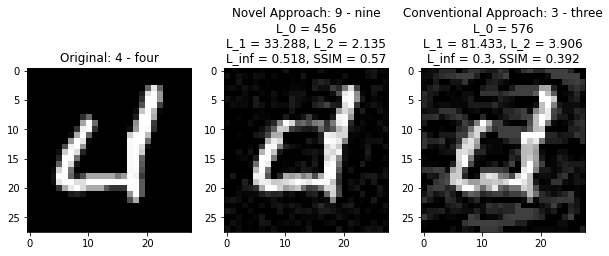

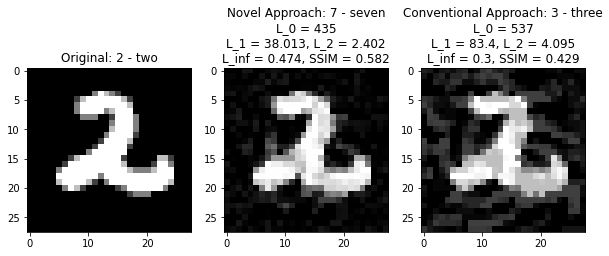

Total Image Count: 1250 Success Rate:
 Novel Approach: 0.9976 Conventional Approach: 0.98
Total Image Count: 1255 Success Rate:
 Novel Approach: 0.9976095617529881 Conventional Approach: 0.9800796812749004
Total Image Count: 1260 Success Rate:
 Novel Approach: 0.9976190476190476 Conventional Approach: 0.9801587301587301
Total Image Count: 1265 Success Rate:
 Novel Approach: 0.9976284584980237 Conventional Approach: 0.9802371541501976
Total Image Count: 1270 Success Rate:
 Novel Approach: 0.9976377952755906 Conventional Approach: 0.9803149606299213
Total Image Count: 1275 Success Rate:
 Novel Approach: 0.9976470588235294 Conventional Approach: 0.9803921568627451
Total Image Count: 1280 Success Rate:
 Novel Approach: 0.99765625 Conventional Approach: 0.98046875
Total Image Count: 1285 Success Rate:
 Novel Approach: 0.9976653696498055 Conventional Approach: 0.980544747081712
Total Image Count: 1290 Success Rate:
 Novel Approach: 0.9976744186046511 Conventional Approach: 0.9806201550387597

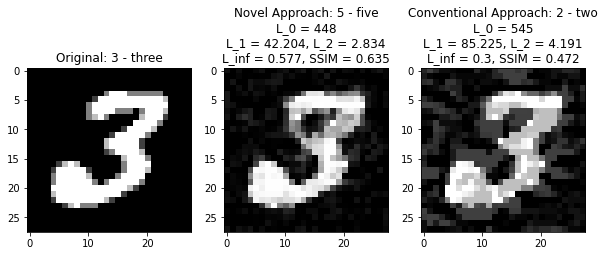

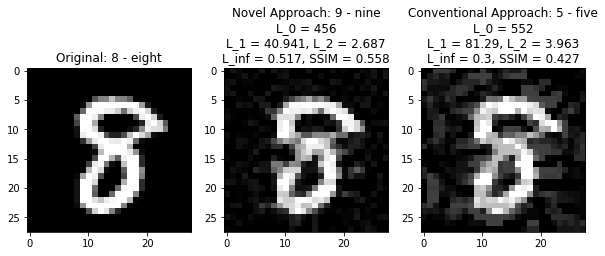

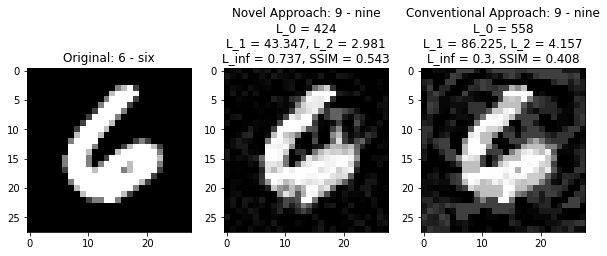

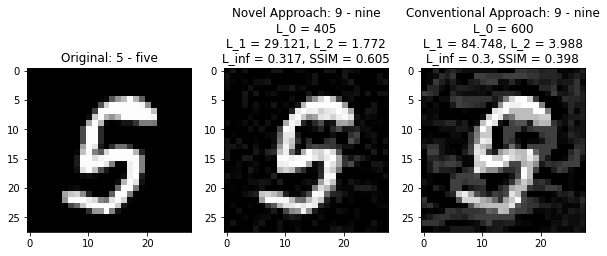

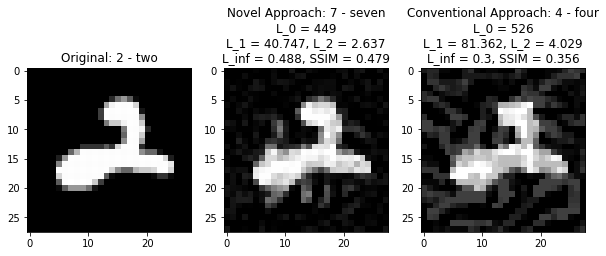

Total Image Count: 1300 Success Rate:
 Novel Approach: 0.9976923076923077 Conventional Approach: 0.9807692307692307
Total Image Count: 1305 Success Rate:
 Novel Approach: 0.9977011494252873 Conventional Approach: 0.9808429118773946
Total Image Count: 1310 Success Rate:
 Novel Approach: 0.9977099236641221 Conventional Approach: 0.9809160305343512
Total Image Count: 1315 Success Rate:
 Novel Approach: 0.9977186311787072 Conventional Approach: 0.9809885931558935
Total Image Count: 1320 Success Rate:
 Novel Approach: 0.9977272727272727 Conventional Approach: 0.9810606060606061
Total Image Count: 1325 Success Rate:
 Novel Approach: 0.9977358490566037 Conventional Approach: 0.9811320754716981
Total Image Count: 1330 Success Rate:
 Novel Approach: 0.9977443609022556 Conventional Approach: 0.981203007518797
Total Image Count: 1335 Success Rate:
 Novel Approach: 0.9977528089887641 Conventional Approach: 0.9812734082397003
Total Image Count: 1340 Success Rate:
 Novel Approach: 0.9977611940298508

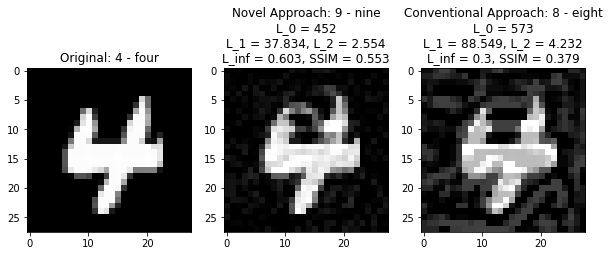

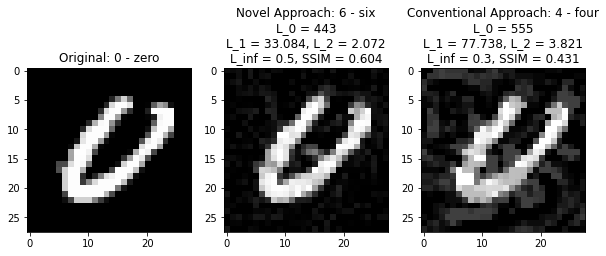

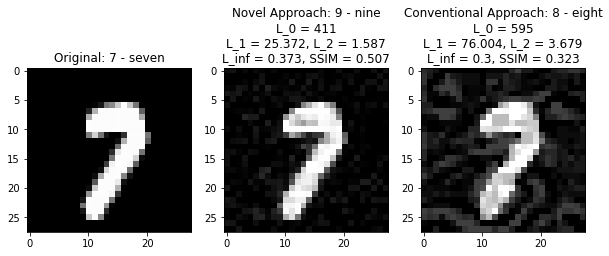

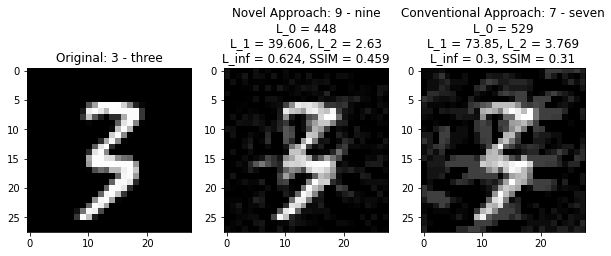

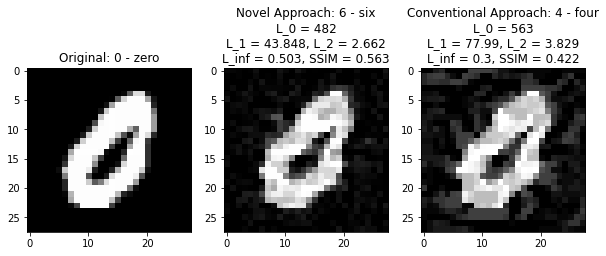

Total Image Count: 1350 Success Rate:
 Novel Approach: 0.9977777777777778 Conventional Approach: 0.9814814814814815
Total Image Count: 1355 Success Rate:
 Novel Approach: 0.9977859778597786 Conventional Approach: 0.981549815498155
Total Image Count: 1360 Success Rate:
 Novel Approach: 0.9977941176470588 Conventional Approach: 0.9816176470588235
Total Image Count: 1365 Success Rate:
 Novel Approach: 0.9978021978021978 Conventional Approach: 0.9809523809523809
Total Image Count: 1370 Success Rate:
 Novel Approach: 0.9978102189781022 Conventional Approach: 0.981021897810219
Total Image Count: 1375 Success Rate:
 Novel Approach: 0.9978181818181818 Conventional Approach: 0.9810909090909091
Total Image Count: 1380 Success Rate:
 Novel Approach: 0.9978260869565218 Conventional Approach: 0.981159420289855
Total Image Count: 1385 Success Rate:
 Novel Approach: 0.9978339350180505 Conventional Approach: 0.9812274368231046
Total Image Count: 1390 Success Rate:
 Novel Approach: 0.9978417266187051 C

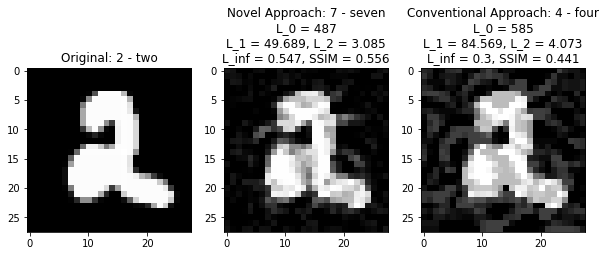

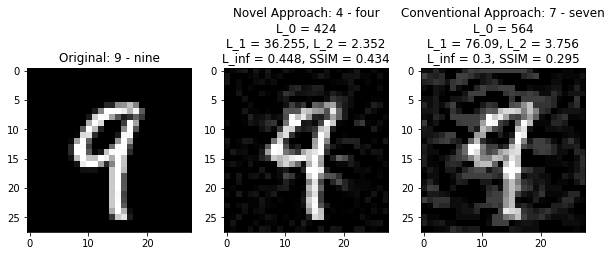

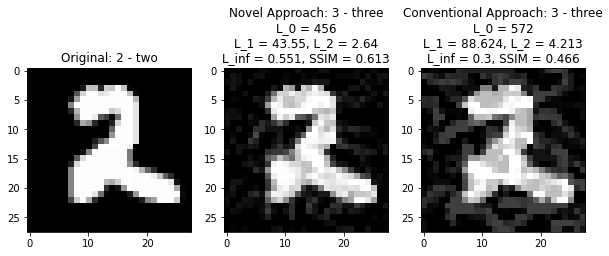

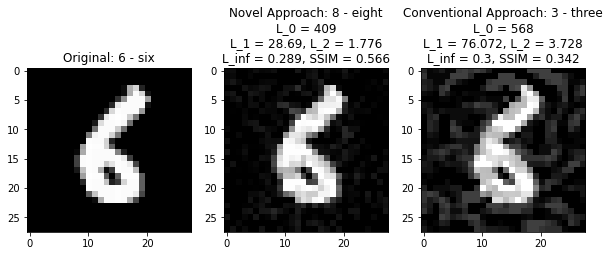

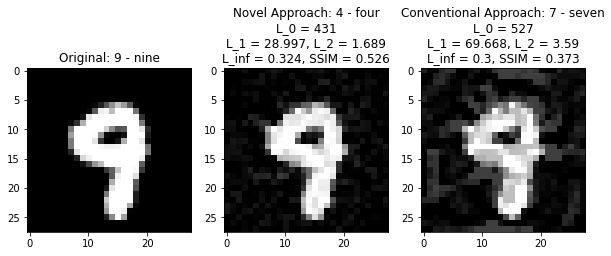

Total Image Count: 1400 Success Rate:
 Novel Approach: 0.9978571428571429 Conventional Approach: 0.9814285714285714
Total Image Count: 1405 Success Rate:
 Novel Approach: 0.9978632478632479 Conventional Approach: 0.9814814814814815
Total Image Count: 1410 Success Rate:
 Novel Approach: 0.9978708303761533 Conventional Approach: 0.9815471965933286
Total Image Count: 1415 Success Rate:
 Novel Approach: 0.9978783592644979 Conventional Approach: 0.9816124469589816
Total Image Count: 1420 Success Rate:
 Novel Approach: 0.9978858350951374 Conventional Approach: 0.981677237491191
Total Image Count: 1425 Success Rate:
 Novel Approach: 0.9978932584269663 Conventional Approach: 0.9817415730337079
Total Image Count: 1430 Success Rate:
 Novel Approach: 0.9979006298110566 Conventional Approach: 0.9818054583624912
Total Image Count: 1435 Success Rate:
 Novel Approach: 0.997907949790795 Conventional Approach: 0.9818688981868898
Total Image Count: 1440 Success Rate:
 Novel Approach: 0.9979152189020153 

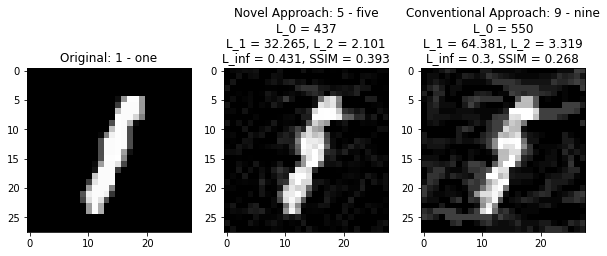

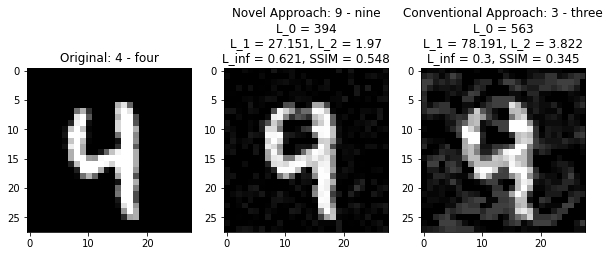

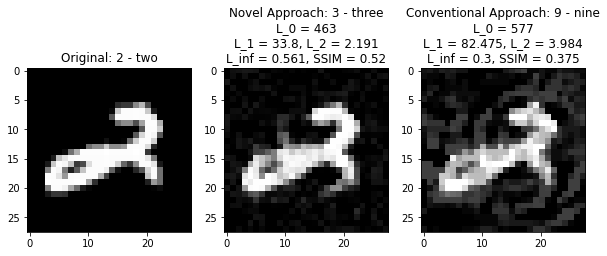

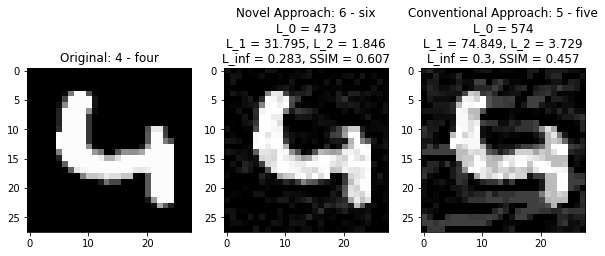

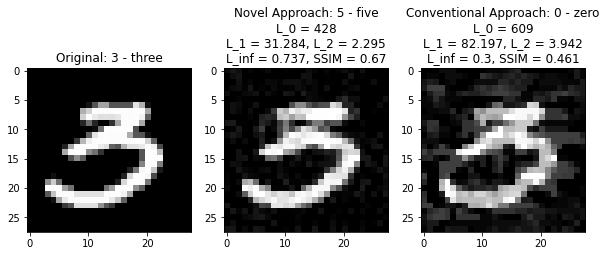

Total Image Count: 1450 Success Rate:
 Novel Approach: 0.9979296066252588 Conventional Approach: 0.9820565907522429
Total Image Count: 1455 Success Rate:
 Novel Approach: 0.9979367262723521 Conventional Approach: 0.9821182943603851
Total Image Count: 1460 Success Rate:
 Novel Approach: 0.997943797121316 Conventional Approach: 0.9821795750514051
Total Image Count: 1465 Success Rate:
 Novel Approach: 0.9979508196721312 Conventional Approach: 0.98224043715847
Total Image Count: 1470 Success Rate:
 Novel Approach: 0.9979577944179714 Conventional Approach: 0.9823008849557522
Total Image Count: 1475 Success Rate:
 Novel Approach: 0.9979647218453188 Conventional Approach: 0.9823609226594301
Total Image Count: 1480 Success Rate:
 Novel Approach: 0.9979716024340771 Conventional Approach: 0.982420554428668
Total Image Count: 1485 Success Rate:
 Novel Approach: 0.9979784366576819 Conventional Approach: 0.9824797843665768


KeyboardInterrupt: 

In [13]:
# PGD TEST
# N = Novel Approach, C = Conventional Approach
model.eval()
success_N = 0
success_C = 0
total = 0
pred_suc = 0
attpre_suc = 0
batch_num = 0
for images, labels in train_loader:
    batch_num += 1
    images = images.to(device)
    labels = labels.to(device)
    outputs_N = model(images)
    _, ori_preds = torch.max(outputs_N, 1)   #original outputs
    index = np.arange(labels.size(0))
    # print(labels.size())
    index = index[ori_preds.cpu() == labels.cpu()]
    # print(images.size())
    images = images[index]
    labels = labels[index]

    # Novel Approach
    att_images_N, deltas = PGD_attack_MyLoss(model, images, labels, eps, step_size)
    att_outputs_N = model(att_images_N)
    _, att_preds_N = torch.max(att_outputs_N, 1)
    success_N += (labels != att_preds_N).sum().item()
    # success += (ori_preds != att_preds_N).sum().item()
    # pred_suc += (ori_preds == labels).sum().item()
    # attpre_suc += (att_preds_N == labels).sum().item()

    # Conventional Approach
    att_images_C = PGD_attack_Conventional(model, images, labels, step_size=0.025)
    att_outputs_C = model(att_images_C)
    _, att_preds_C = torch.max(att_outputs_C.data, 1)
    success_C += (labels != att_preds_C).sum().item()

    # Display Result
    total += labels.size(0)
    if(batch_num % 10 == 0):
        for i in range (0, images.size()[0]):
            triple_imshow(torchvision.utils.make_grid(images[i].data, normalize=True),
                        torchvision.utils.make_grid(att_images_N[i].data, normalize=True),
                        torchvision.utils.make_grid(att_images_C[i].data, normalize=True),
                        "Original: " + str(train_dataset.classes[labels[i]]),
                        "Novel Approach: " + str(train_dataset.classes[att_preds_N[i]])
                        + '\n' + "L_0 = " + str(round(l0(images[i], att_images_N[i]), 3))
                        + '\n' + "L_1 = " + str(round(l1(images[i],att_images_N[i]),3))
                        + ", L_2 = " + str(round(l2(images[i], att_images_N[i]),3))
                        + '\n' + 'L_inf = ' + str(round(deltas[i],3)) + ', SSIM = ' +
                        str(round(pytorch_ssim.ssim(images[i].unsqueeze(0),att_images_N[i].unsqueeze(0)).item(),3)),
                        "Conventional Approach: " +str(train_dataset.classes[att_preds_C[i]])
                        + '\n' + "L_0 = " + str(round(l0(images[i], att_images_C[i]), 3))
                        + '\n' + "L_1 = " + str(round(l1(images[i],att_images_C[i]),3))
                        + ", L_2 = " + str(round(l2(images[i],att_images_C[i]),3))
                        + '\n' + 'L_inf = ' + str(0.3) + ', SSIM = ' +
                        str(round(pytorch_ssim.ssim(images[i].unsqueeze(0), att_images_C[i].unsqueeze(0)).item(), 3)),
                        5 * batch_num - 4 + i)
    #     double_imshow(torchvision.utils.make_grid(images[i].data, normalize=True),
    #                     torchvision.utils.make_grid(att_images_N[i].data, normalize=True),
    #                     "Original: " + str(train_dataset.classes[labels[i]]),
    #                     "Novel Approach: " + str(train_dataset.classes[att_preds_N[i]])
    #                     + '\n' + str(round(deltas[i],3)))
    #     print('SSIM_N = ' + str(round(pytorch_ssim.ssim(images[i].unsqueeze(0),att_images_N[i].unsqueeze(0)).item(),3)))
    #     print('SSIM_C = ' + str(round(pytorch_ssim.ssim(images[i].unsqueeze(0), att_images_C[i].unsqueeze(0)).item(), 3)))

    print("Total Image Count:", 5 * batch_num,"Success Rate:\n", "Novel Approach:", success_N / total, "Conventional Approach:", success_C / total)
    if(batch_num >=  300):
        break